## Metalearning Test V1

Processing VIX data...
VIX data loaded successfully!
Data range: 1990-04-02 00:00:00 to 2025-05-09 00:00:00
Number of days: 8861

Preparing VIX data for forecasting...

Forecasting dataset created:
Training samples: 7024
Testing samples: 1757
Input shape: (7024, 60, 14)
Target shape: (7024, 21, 1)

Data saved to 'data/meta_learning/vix_data.pt' and 'data/meta_learning/vix_model_data.pt'


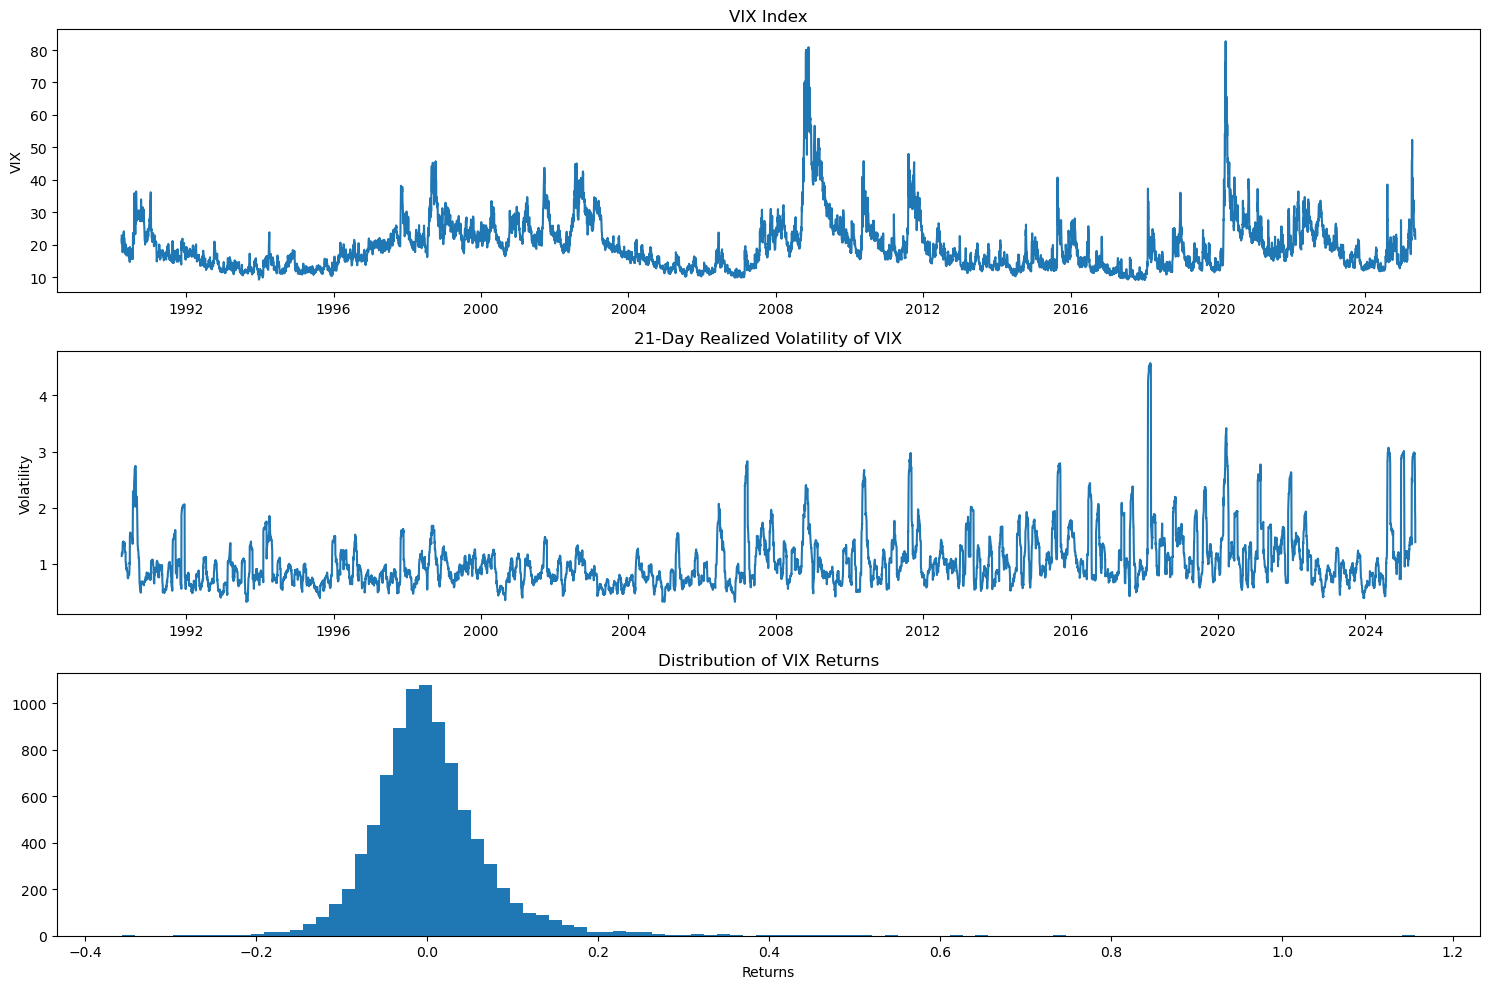

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import datetime as dt

def process_vix_data(file_path):
    """Process VIX data from CSV file"""
    
    # Read the data
    # Assuming the data is in a CSV format with the columns as shown
    df = pd.read_csv(file_path, parse_dates=['DATE'])
    
    # Rename columns to standard format
    df.columns = [col.lower() for col in df.columns]
    
    # Set the date as the index
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['returns'] = df['close'].pct_change()
    
    # Calculate volatility features
    # Historical volatility (standard deviation of returns)
    df['vol_5d'] = df['returns'].rolling(5).std() * np.sqrt(252)  # 1-week
    df['vol_10d'] = df['returns'].rolling(10).std() * np.sqrt(252)  # 2-weeks
    df['vol_21d'] = df['returns'].rolling(21).std() * np.sqrt(252)  # 1-month (target)
    df['vol_63d'] = df['returns'].rolling(63).std() * np.sqrt(252)  # 3-months
    
    # Moving averages
    df['ma5'] = df['close'].rolling(5).mean()
    df['ma20'] = df['close'].rolling(20).mean()
    df['ma50'] = df['close'].rolling(50).mean()
    
    # Price to moving average ratios
    df['price_to_ma20'] = df['close'] / df['ma20']
    df['price_to_ma50'] = df['close'] / df['ma50']
    
    # Range-based volatility
    df['daily_range'] = (df['high'] - df['low']) / df['close']
    df['range_ma5'] = df['daily_range'].rolling(5).mean()
    
    # Momentum features
    df['momentum_5d'] = df['close'].pct_change(5)
    df['momentum_10d'] = df['close'].pct_change(10)
    df['momentum_21d'] = df['close'].pct_change(21)
    
    # Calendar features
    df['day_of_week'] = df.index.dayofweek / 6.0
    df['month'] = (df.index.month - 1) / 11.0
    df['quarter'] = (df.index.quarter - 1) / 3.0
    df['year'] = (df.index.year - df.index.year.min()) / (df.index.year.max() - df.index.year.min())
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    return df

def prepare_vix_data_for_forecasting(df, window_size=60, forecast_horizon=21, test_ratio=0.2):
    """Prepare VIX data for forecasting"""
    
    # Define feature columns
    feature_cols = [
        'vol_5d', 'vol_10d', 'vol_63d', 
        'price_to_ma20', 'price_to_ma50',
        'daily_range', 'range_ma5',
        'momentum_5d', 'momentum_10d', 'momentum_21d',
        'day_of_week', 'month', 'quarter', 'year'
    ]
    
    # Target column
    target_col = 'vol_21d'
    
    # Scale features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Create a copy
    df_scaled = df.copy()
    
    # Fit and transform
    df_scaled[feature_cols] = scaler_features.fit_transform(df[feature_cols])
    df_scaled[[target_col]] = scaler_target.fit_transform(df[[target_col]])
    
    # Extract scaled data
    X = df_scaled[feature_cols].values
    y = df_scaled[target_col].values
    
    # Create sliding windows
    X_windows, y_windows = [], []
    
    for i in range(len(df) - window_size - forecast_horizon + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size:i+window_size+forecast_horizon])
    
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)  # Add feature dimension
    
    # Split into train/test
    split_idx = int(len(X_windows) * (1 - test_ratio))
    
    # Create a task ID for this series (just 0 since it's a single series)
    task_id = np.zeros(len(X_windows), dtype=int)
    
    data = {
        'X_train': X_windows[:split_idx],
        'y_train': y_windows[:split_idx],
        'task_id_train': task_id[:split_idx],
        'X_test': X_windows[split_idx:],
        'y_test': y_windows[split_idx:],
        'task_id_test': task_id[split_idx:],
        'feature_scaler': scaler_features,
        'target_scaler': scaler_target,
        'feature_cols': feature_cols,
        'target_col': target_col,
        'dates': df.index,
        'raw_data': df
    }
    
    return data

def format_vix_for_models(data, val_ratio=0.1):
    """Format VIX data for TFT, NBEATSx, and DeepAR models"""
    
    # Split training data into train/val
    n_train = len(data['X_train'])
    val_idx = int(n_train * (1 - val_ratio))
    
    X_train = data['X_train'][:val_idx]
    y_train = data['y_train'][:val_idx]
    task_train = data['task_id_train'][:val_idx]
    
    X_val = data['X_train'][val_idx:]
    y_val = data['y_train'][val_idx:]
    task_val = data['task_id_train'][val_idx:]
    
    X_test = data['X_test']
    y_test = data['y_test']
    task_test = data['task_id_test']
    
    # Format for different models
    model_data = {}
    
    # 1. TFT Format
    # Identify calendar features (known in the future)
    calendar_indices = [-4, -3, -2, -1]  # day_of_week, month, quarter, year indices
    
    tft_data = {
        'train': {
            'static_inputs': [torch.tensor(task_train, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_train, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                # Calendar features for the forecast horizon
                # In a real application, we would use actual future calendar features
                # Here we'll just use zeros as placeholders
                torch.zeros((X_train.shape[0], y_train.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'static_inputs': [torch.tensor(task_val, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_val, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                torch.zeros((X_val.shape[0], y_val.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'static_inputs': [torch.tensor(task_test, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_test, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                torch.zeros((X_test.shape[0], y_test.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['tft'] = tft_data
    
    # 2. NBEATSx Format
    nbeatsx_data = {
        'train': {
            'x': torch.tensor(X_train, dtype=torch.float32),
            'y': torch.tensor(y_train.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_train, dtype=torch.long)
        },
        'val': {
            'x': torch.tensor(X_val, dtype=torch.float32),
            'y': torch.tensor(y_val.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_val, dtype=torch.long)
        },
        'test': {
            'x': torch.tensor(X_test, dtype=torch.float32),
            'y': torch.tensor(y_test.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_test, dtype=torch.long)
        }
    }
    model_data['nbeatsx'] = nbeatsx_data
    
    # 3. DeepAR Format
    # Use VIX itself as the main series and the rest as features
    deepar_data = {
        'train': {
            'time_series': torch.tensor(X_train[:, :, 0:1], dtype=torch.float32),  # Just using vol_5d as the main series
            'time_features': torch.tensor(X_train[:, :, 1:], dtype=torch.float32),  # Rest as time features
            'static_features': torch.tensor(task_train.reshape(-1, 1), dtype=torch.float32),  # Task IDs as static features
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'time_series': torch.tensor(X_val[:, :, 0:1], dtype=torch.float32),
            'time_features': torch.tensor(X_val[:, :, 1:], dtype=torch.float32),
            'static_features': torch.tensor(task_val.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'time_series': torch.tensor(X_test[:, :, 0:1], dtype=torch.float32),
            'time_features': torch.tensor(X_test[:, :, 1:], dtype=torch.float32),
            'static_features': torch.tensor(task_test.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['deepar'] = deepar_data
    
    return model_data

def main_vix(file_path):
    """Main function for processing VIX data"""
    
    print("Processing VIX data...")
    vix_df = process_vix_data(file_path)
    
    print("VIX data loaded successfully!")
    print(f"Data range: {vix_df.index.min()} to {vix_df.index.max()}")
    print(f"Number of days: {len(vix_df)}")
    
    # Plot the VIX data
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(vix_df.index, vix_df['close'])
    plt.title('VIX Index')
    plt.ylabel('VIX')
    
    plt.subplot(3, 1, 2)
    plt.plot(vix_df.index, vix_df['vol_21d'])
    plt.title('21-Day Realized Volatility of VIX')
    plt.ylabel('Volatility')
    
    plt.subplot(3, 1, 3)
    plt.hist(vix_df['returns'], bins=100)
    plt.title('Distribution of VIX Returns')
    plt.xlabel('Returns')
    
    plt.tight_layout()
    plt.savefig('figures/meta_learning/vix_analysis.png')
    
    # Prepare for forecasting
    print("\nPreparing VIX data for forecasting...")
    vix_data = prepare_vix_data_for_forecasting(
        vix_df,
        window_size=60,     # 60 days of history
        forecast_horizon=21,  # 21 days ahead
        test_ratio=0.2
    )
    
    print(f"\nForecasting dataset created:")
    print(f"Training samples: {len(vix_data['X_train'])}")
    print(f"Testing samples: {len(vix_data['X_test'])}")
    print(f"Input shape: {vix_data['X_train'].shape}")
    print(f"Target shape: {vix_data['y_train'].shape}")
    
    # Format for models
    model_data = format_vix_for_models(vix_data)
    
    # Save the prepared data
    torch.save(vix_data, 'data/meta_learning/vix_data.pt')
    torch.save(model_data, 'data/meta_learning/vix_model_data.pt')
    print("\nData saved to 'data/meta_learning/vix_data.pt' and 'data/meta_learning/vix_model_data.pt'")
    
    return vix_data, model_data

if __name__ == "__main__":
    # Replace with the path to your VIX data file
    file_path = "data/real/cboe_data/VIX_History.csv"
    vix_data, model_data = main_vix(file_path)

## This cell ##
1. Fetches economic indicators from FRED that correlate with market volatility
2. Processes your VIX data from the CSV file
3. Combines and enhances the dataset with additional features
4. Creates data visualizations to help you understand the data
5. Prepares time series windows for forecasting models
6. Formats the data specifically for TFT, NBEATSx, and DeepAR
7. Saves everything in appropriate formats (CSV for raw data, PyTorch tensors for model inputs, JSON for feature information)

In [19]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import torch
from sklearn.preprocessing import StandardScaler

# Create a data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# 1. Define function to get FRED data
def get_fred_exog_data(start_date='1990-01-01', end_date='2023-01-01'):
    """Get exogenous variables from FRED for volatility forecasting"""
    
    print(f"Fetching data from FRED ({start_date} to {end_date})...")
    
    # Dictionary of indicators to fetch
    indicators = {
        'VIX': 'VIXCLS',                # VIX (our target)
        'SP500': 'SP500',               # S&P 500 Index
        'T10Y2Y': 'T10Y2Y',             # 10Y-2Y Treasury Spread (recession indicator)
        'UNRATE': 'UNRATE',             # Unemployment Rate
        'STLFSI': 'STLFSI2',            # St. Louis Fed Financial Stress Index
        'BAA10Y': 'BAA10Y',             # BAA Corporate Bond - 10Y Treasury Spread
        'TEDRATE': 'TEDRATE',           # TED Spread (3M LIBOR - 3M T-Bill)
        'USREC': 'USREC',               # US Recession Indicator
        'T10YIE': 'T10YIE',             # 10-Year Breakeven Inflation Rate
        'CFNAI': 'CFNAI'                # Chicago Fed National Activity Index
    }
    
    # Fetch data
    data = {}
    for name, fred_code in indicators.items():
        try:
            print(f"  Fetching {name} ({fred_code})...")
            series = pdr.get_data_fred(fred_code, start_date, end_date)
            if isinstance(series, pd.DataFrame):
                series.columns = [name]
            else:
                series = pd.DataFrame({name: series})
            data[name] = series
        except Exception as e:
            print(f"  Error fetching {name}: {e}")
    
    # Combine all series
    print("Combining data series...")
    combined = pd.concat([data[name] for name in data if name in data], axis=1)
    
    # Fill missing values with forward fill then backward fill
    combined = combined.fillna(method='ffill').fillna(method='bfill')
    
    print(f"FRED data retrieved with {len(combined)} rows and {combined.shape[1]} columns.")
    return combined, data

# 2. Process existing VIX data if available
def process_vix_data(file_path):
    """Process VIX data from CSV file"""
    
    print(f"Processing VIX data from {file_path}...")
    
    # Read the data
    df = pd.read_csv(file_path)
    
    # Check if DATE column exists, if not, try other formats
    if 'DATE' in df.columns:
        date_col = 'DATE'
    elif 'Date' in df.columns:
        date_col = 'Date'
    else:
        # If no obvious date column, try to find it
        for col in df.columns:
            if df[col].dtype == 'object' and pd.to_datetime(df[col], errors='coerce').notna().all():
                date_col = col
                break
        else:
            raise ValueError("Could not identify date column in VIX data")
    
    # Convert date to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Standardize column names
    df.columns = [col.lower() for col in df.columns]
    date_col = date_col.lower()
    
    # Set date as index
    df.set_index(date_col, inplace=True)
    
    # Ensure required columns exist
    required_cols = ['close']
    if not all(col in df.columns for col in required_cols):
        # Try to identify close column
        for col in df.columns:
            if 'close' in col.lower() or 'last' in col.lower() or 'price' in col.lower():
                df['close'] = df[col]
                break
        else:
            raise ValueError("Required column 'close' not found in VIX data")
    
    print(f"VIX data processed with {len(df)} rows.")
    return df

# 3. Create calendar and Fed meeting features
def create_calendar_features(df):
    """Create calendar features and scheduled event indicators"""
    
    print("Creating calendar and event features...")
    
    # Basic calendar features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    
    # Cyclical encoding of calendar features
    df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 5))  # 5 trading days
    df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 5))
    df['day_of_month_sin'] = np.sin((df['day_of_month'] - 1) * (2 * np.pi / 31))
    df['day_of_month_cos'] = np.cos((df['day_of_month'] - 1) * (2 * np.pi / 31))
    df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))
    df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))
    
    # Month-end indicator (useful for financial data)
    df['month_end'] = df.index.is_month_end.astype(int)
    df['quarter_end'] = df.index.is_quarter_end.astype(int)
    df['year_end'] = df.index.is_year_end.astype(int)
    
    # Create FOMC meeting indicators (approximate dates, would need to be refined with actual data)
    # This is a simplified approach - ideally you'd load the actual FOMC calendar
    fomc_meetings = []
    years = df.index.year.unique()
    for year in years:
        # Approximate FOMC dates (typically 8 meetings per year)
        for month in [1, 3, 5, 6, 8, 9, 11, 12]:
            # Meetings often occur mid-month
            fomc_meetings.append(pd.Timestamp(f"{year}-{month}-15"))
    
    # Create indicator for days near FOMC meetings
    df['fomc_meeting'] = 0
    for meeting_date in fomc_meetings:
        # Mark 3 days before and after as FOMC-related
        window_start = meeting_date - pd.Timedelta(days=3)
        window_end = meeting_date + pd.Timedelta(days=3)
        df.loc[window_start:window_end, 'fomc_meeting'] = 1
    
    return df

# 4. Combine data and compute additional features
def prepare_combined_data(vix_df, exog_df):
    """Combine VIX and exogenous data, compute additional features"""
    
    print("Combining and enhancing the dataset...")
    
    # Merge VIX and exogenous data on date index
    df = vix_df.join(exog_df, how='inner')
    print(f"Combined dataset has {len(df)} rows and {df.shape[1]} columns.")
    
    # Calculate returns for VIX and S&P 500
    if 'close' in df.columns and 'SP500' in df.columns:
        df['vix_returns'] = df['close'].pct_change()
        df['sp500_returns'] = df['SP500'].pct_change()
        
        # Correlation between VIX and S&P 500 (rolling 30-day window)
        df['vix_sp500_corr'] = df['vix_returns'].rolling(30).corr(df['sp500_returns'])
    
    # Volatility features
    if 'vix_returns' in df.columns:
        df['vol_5d'] = df['vix_returns'].rolling(5).std() * np.sqrt(252)  # 1-week
        df['vol_10d'] = df['vix_returns'].rolling(10).std() * np.sqrt(252)  # 2-weeks
        df['vol_21d'] = df['vix_returns'].rolling(21).std() * np.sqrt(252)  # 1-month (target)
        df['vol_63d'] = df['vix_returns'].rolling(63).std() * np.sqrt(252)  # 3-months
    
    # Technical indicators
    if 'close' in df.columns:
        # Moving averages
        df['ma5'] = df['close'].rolling(5).mean()
        df['ma20'] = df['close'].rolling(20).mean()
        df['ma50'] = df['close'].rolling(50).mean()
        
        # Price to moving average ratios
        df['price_to_ma20'] = df['close'] / df['ma20']
        df['price_to_ma50'] = df['close'] / df['ma50']
        
        # Momentum features
        df['momentum_5d'] = df['close'].pct_change(5)
        df['momentum_10d'] = df['close'].pct_change(10)
        df['momentum_21d'] = df['close'].pct_change(21)
    
    # Volatility regime classification (simplified)
    if 'close' in df.columns:
        # Calculate long-term average and standard deviation
        long_term_avg = df['close'].rolling(252).mean()
        long_term_std = df['close'].rolling(252).std()
        
        # Classify regimes based on z-score
        df['vix_zscore'] = (df['close'] - long_term_avg) / long_term_std
        
        # Create regime indicators (0: low vol, 1: normal, 2: high vol)
        df['regime'] = 1  # Default to normal regime
        df.loc[df['vix_zscore'] < -1, 'regime'] = 0  # Low volatility
        df.loc[df['vix_zscore'] > 1, 'regime'] = 2  # High volatility
        
        # One-hot encode regimes
        df['regime_low'] = (df['regime'] == 0).astype(int)
        df['regime_normal'] = (df['regime'] == 1).astype(int)
        df['regime_high'] = (df['regime'] == 2).astype(int)
    
    # Add calendar features
    df = create_calendar_features(df)
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    print(f"Final dataset has {len(df)} rows and {df.shape[1]} columns after feature engineering.")
    return df

# 5. Prepare data for forecasting models
def prepare_for_forecasting(df, window_size=60, forecast_horizon=21, test_ratio=0.2):
    """Prepare final dataset for forecasting models"""
    
    print(f"Preparing forecasting dataset with {window_size}-day input windows and {forecast_horizon}-day forecast horizon...")
    
    # Define feature groups
    # These groups help with model-specific data formatting
    feature_groups = {
        'target': ['vol_21d'],  # Target variable to forecast
        
        'price_features': [  # Basic price and volatility features
            'close', 'vol_5d', 'vol_10d', 'vol_63d', 
            'price_to_ma20', 'price_to_ma50'
        ],
        
        'technical_indicators': [  # Technical analysis features
            'momentum_5d', 'momentum_10d', 'momentum_21d'
        ],
        
        'calendar_features': [  # Known future temporal features
            'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',
            'month_end', 'quarter_end', 'year_end'
        ],
        
        'macro_indicators': [  # Macroeconomic context
            'T10Y2Y', 'UNRATE', 'STLFSI', 'BAA10Y', 'TEDRATE', 'USREC', 'CFNAI'
        ],
        
        'market_indicators': [  # Market-specific indicators
            'SP500', 'vix_sp500_corr'
        ],
        
        'static_features': [  # Features that mostly remain constant for a time series
            'regime_low', 'regime_normal', 'regime_high'
        ],
        
        'event_indicators': [  # Scheduled events (known in future)
            'fomc_meeting'
        ]
    }
    
    # Create merged feature lists for different models
    all_features = []
    for group in feature_groups.values():
        all_features.extend([col for col in group if col in df.columns])
    
    # Filter to include only columns that exist in the dataframe
    feature_groups = {
        key: [col for col in group if col in df.columns] 
        for key, group in feature_groups.items()
    }
    
    # Define target column
    target_col = 'vol_21d'  # 21-day volatility is our target
    
    # Check if target exists
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found. Using 'close' as target.")
        target_col = 'close'
    
    # Scale features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Create a copy for scaling
    df_scaled = df.copy()
    
    # Fit and transform
    all_available_features = [col for col in all_features if col in df.columns]
    
    # Ensure all necessary columns exist
    if not all_available_features:
        raise ValueError("No valid features found in the dataset")
    
    df_scaled[all_available_features] = scaler_features.fit_transform(df[all_available_features])
    df_scaled[[target_col]] = scaler_target.fit_transform(df[[target_col]])
    
    # Extract scaled data
    X = df_scaled[all_available_features].values
    y = df_scaled[target_col].values
    
    # Create sliding windows
    X_windows, y_windows = [], []
    
    for i in range(len(df) - window_size - forecast_horizon + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size:i+window_size+forecast_horizon])
    
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)  # Add feature dimension
    
    # Split into train/test
    split_idx = int(len(X_windows) * (1 - test_ratio))
    
    # Create a task ID for this series (just 0 since it's a single series)
    task_id = np.zeros(len(X_windows), dtype=int)
    
    # Create structured data dictionary
    forecasting_data = {
        'X_train': X_windows[:split_idx],
        'y_train': y_windows[:split_idx],
        'task_id_train': task_id[:split_idx],
        'X_test': X_windows[split_idx:],
        'y_test': y_windows[split_idx:],
        'task_id_test': task_id[split_idx:],
        'feature_scaler': scaler_features,
        'target_scaler': scaler_target,
        'feature_cols': all_available_features,
        'feature_groups': feature_groups,
        'target_col': target_col,
        'dates': df.index,
        'raw_data': df
    }
    
    print(f"Created forecasting dataset:")
    print(f"  Training samples: {len(forecasting_data['X_train'])}")
    print(f"  Testing samples: {len(forecasting_data['X_test'])}")
    print(f"  Input shape: {forecasting_data['X_train'].shape}")
    print(f"  Target shape: {forecasting_data['y_train'].shape}")
    
    return forecasting_data

# 6. Visualize some of the data
def visualize_data(df, file_path='figures/meta_learning/vix_analysis.png'):
    """Create visualizations of the data"""
    
    print("Creating visualizations...")
    
    plt.figure(figsize=(15, 12))
    
    # VIX and S&P 500
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['close'], label='VIX')
    plt.title('VIX Index')
    plt.ylabel('VIX')
    plt.legend()
    
    # If we have SP500 data, plot on secondary axis
    if 'SP500' in df.columns:
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(df.index, df['SP500'], 'g-', label='S&P 500')
        ax2.set_ylabel('S&P 500', color='g')
        ax2.legend(loc='upper right')
    
    # Volatility metrics
    plt.subplot(3, 1, 2)
    if 'vol_21d' in df.columns:
        plt.plot(df.index, df['vol_21d'], label='21-Day Volatility')
    if 'vol_63d' in df.columns:
        plt.plot(df.index, df['vol_63d'], label='63-Day Volatility')
    plt.title('Volatility Metrics')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    
    # Economic indicators
    plt.subplot(3, 1, 3)
    if 'STLFSI' in df.columns:
        plt.plot(df.index, df['STLFSI'], label='Financial Stress Index')
    if 'T10Y2Y' in df.columns:
        plt.plot(df.index, df['T10Y2Y'], label='10Y-2Y Spread')
    if 'USREC' in df.columns:
        # Recession shading
        recession_periods = []
        in_recession = False
        start_date = None
        
        for date, value in df['USREC'].items():
            if value == 1 and not in_recession:
                in_recession = True
                start_date = date
            elif value == 0 and in_recession:
                in_recession = False
                recession_periods.append((start_date, date))
        
        # Draw recession shading
        for start, end in recession_periods:
            plt.axvspan(start, end, color='gray', alpha=0.3)
        
    plt.title('Economic Indicators')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    
    print(f"Visualization saved to {file_path}")

# 7. Format data for specific models
def format_data_for_models(forecasting_data):
    """Format the forecasting data for TFT, NBEATSx, and DeepAR models"""
    
    print("Formatting data for specific models...")
    
    # Split training data into train/val (90/10 split)
    val_ratio = 0.1
    n_train = len(forecasting_data['X_train'])
    val_idx = int(n_train * (1 - val_ratio))
    
    X_train = forecasting_data['X_train'][:val_idx]
    y_train = forecasting_data['y_train'][:val_idx]
    task_train = forecasting_data['task_id_train'][:val_idx]
    
    X_val = forecasting_data['X_train'][val_idx:]
    y_val = forecasting_data['y_train'][val_idx:]
    task_val = forecasting_data['task_id_train'][val_idx:]
    
    X_test = forecasting_data['X_test']
    y_test = forecasting_data['y_test']
    task_test = forecasting_data['task_id_test']
    
    feature_groups = forecasting_data['feature_groups']
    all_features = forecasting_data['feature_cols']
    
    # Get indices for different feature groups
    future_known_indices = []
    static_indices = []
    
    # Find indices for calendar and event features (future known)
    for feature_type in ['calendar_features', 'event_indicators']:
        if feature_type in feature_groups:
            for feature in feature_groups[feature_type]:
                if feature in all_features:
                    future_known_indices.append(all_features.index(feature))
    
    # Find indices for static features
    if 'static_features' in feature_groups:
        for feature in feature_groups['static_features']:
            if feature in all_features:
                static_indices.append(all_features.index(feature))
    
    # Format for different models
    model_data = {}
    
    # 1. TFT Format
    # TFT needs: static_inputs, encoder_inputs, decoder_inputs
    
    # Extract static features if any exist
    static_inputs = None
    if static_indices:
        # Get static features (use the first timestep of each window)
        static_train = X_train[:, 0, static_indices]
        static_val = X_val[:, 0, static_indices]
        static_test = X_test[:, 0, static_indices]
        
        static_inputs = [
            torch.tensor(static_train, dtype=torch.float32),
            torch.tensor(static_val, dtype=torch.float32),
            torch.tensor(static_test, dtype=torch.float32)
        ]
    
    # Add task IDs as another static input
    task_inputs = [
        torch.tensor(task_train, dtype=torch.long),
        torch.tensor(task_val, dtype=torch.long),
        torch.tensor(task_test, dtype=torch.long)
    ]
    
    # Create future inputs for decoder (calendar features)
    future_inputs = None
    if future_known_indices:
        # For real data, we would extract actual future values
        # For this example, we'll use placeholder zeros
        future_train = np.zeros((X_train.shape[0], y_train.shape[1], len(future_known_indices)))
        future_val = np.zeros((X_val.shape[0], y_val.shape[1], len(future_known_indices)))
        future_test = np.zeros((X_test.shape[0], y_test.shape[1], len(future_known_indices)))
        
        future_inputs = [
            torch.tensor(future_train, dtype=torch.float32),
            torch.tensor(future_val, dtype=torch.float32),
            torch.tensor(future_test, dtype=torch.float32)
        ]
    
    tft_data = {
        'train': {
            'static_inputs': [task_inputs[0]] + ([static_inputs[0]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_train, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[0]] if future_inputs else [],
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'static_inputs': [task_inputs[1]] + ([static_inputs[1]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_val, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[1]] if future_inputs else [],
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'static_inputs': [task_inputs[2]] + ([static_inputs[2]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_test, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[2]] if future_inputs else [],
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['tft'] = tft_data
    
    # 2. NBEATSx Format
    # NBEATSx needs: x (time series) and optional exogenous variables
    nbeatsx_data = {
        'train': {
            'x': torch.tensor(X_train, dtype=torch.float32),
            'y': torch.tensor(y_train.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_train, dtype=torch.long)
        },
        'val': {
            'x': torch.tensor(X_val, dtype=torch.float32),
            'y': torch.tensor(y_val.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_val, dtype=torch.long)
        },
        'test': {
            'x': torch.tensor(X_test, dtype=torch.float32),
            'y': torch.tensor(y_test.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_test, dtype=torch.long)
        }
    }
    model_data['nbeatsx'] = nbeatsx_data
    
    # 3. DeepAR Format
    # DeepAR needs: time_series, time_features, static_features
    
    # Use first feature as main time series
    main_series_train = X_train[:, :, 0:1]
    main_series_val = X_val[:, :, 0:1]
    main_series_test = X_test[:, :, 0:1]
    
    # Rest as time features
    time_features_train = X_train[:, :, 1:]
    time_features_val = X_val[:, :, 1:]
    time_features_test = X_test[:, :, 1:]
    
    deepar_data = {
        'train': {
            'time_series': torch.tensor(main_series_train, dtype=torch.float32),
            'time_features': torch.tensor(time_features_train, dtype=torch.float32),
            'static_features': torch.tensor(task_train.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'time_series': torch.tensor(main_series_val, dtype=torch.float32),
            'time_features': torch.tensor(time_features_val, dtype=torch.float32),
            'static_features': torch.tensor(task_val.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'time_series': torch.tensor(main_series_test, dtype=torch.float32),
            'time_features': torch.tensor(time_features_test, dtype=torch.float32),
            'static_features': torch.tensor(task_test.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['deepar'] = deepar_data
    
    print("Data formatted for TFT, NBEATSx, and DeepAR models.")
    return model_data

# 8. Main function
def main(vix_path, start_date='1990-01-01', end_date='2023-01-01'):
    """Main function to execute the data preparation pipeline"""
    
    # Step 1: Get exogenous data from FRED
    exog_data, individual_series = get_fred_exog_data(start_date, end_date)
    exog_data.to_csv('data/meta_learning/fred_indicators.csv')
    
    # Step 2: Process VIX data
    vix_df = process_vix_data(vix_path)
    vix_df.to_csv('data/meta_learning/vix_processed.csv')
    
    # Step 3: Combine and enhance
    combined_df = prepare_combined_data(vix_df, exog_data)
    combined_df.to_csv('data/meta_learning/vix_enhanced.csv')
    
    # Step 4: Visualize the data
    visualize_data(combined_df, 'figures/vix_analysis.png')
    
    # Step 5: Prepare for forecasting
    forecasting_data = prepare_for_forecasting(
        combined_df, 
        window_size=60,        # 60 days of history
        forecast_horizon=21,   # 21 days ahead
        test_ratio=0.2         # 80% train, 20% test
    )
    
    # Step 6: Format for models
    model_data = format_data_for_models(forecasting_data)
    
    # Step 7: Save everything
    torch.save(forecasting_data, 'data/meta_learning/vix_forecasting_data.pt')
    torch.save(model_data, 'data/meta_learning/vix_model_data.pt')
    
    # Save feature information separately for easier reference
    feature_info = {
        'feature_groups': forecasting_data['feature_groups'],
        'all_features': forecasting_data['feature_cols'],
        'target': forecasting_data['target_col']
    }
    with open('data/meta_learning/feature_info.json', 'w') as f:
        import json
        # Convert keys to strings for JSON serialization
        feature_info_str = {k: v for k, v in feature_info.items()}
        feature_info_str['feature_groups'] = {k: v for k, v in feature_info_str['feature_groups'].items()}
        json.dump(feature_info_str, f, indent=2)
    
    print("\nData preparation complete! Files saved to 'data/' directory.")
    print("Now you can use these datasets to train your meta-learning framework.")
    
    return forecasting_data, model_data

# Run the pipeline
if __name__ == "__main__":
    vix_path = "data/real/cboe_data/VIX_History.csv"  # Path to your VIX data file
    forecasting_data, model_data = main(vix_path, start_date='1990-01-01', end_date='2023-01-01')

Fetching data from FRED (1990-01-01 to 2023-01-01)...
  Fetching VIX (VIXCLS)...
  Fetching SP500 (SP500)...
  Fetching T10Y2Y (T10Y2Y)...
  Fetching UNRATE (UNRATE)...
  Fetching STLFSI (STLFSI2)...
  Fetching BAA10Y (BAA10Y)...
  Fetching TEDRATE (TEDRATE)...
  Fetching USREC (USREC)...
  Fetching T10YIE (T10YIE)...
  Fetching CFNAI (CFNAI)...
Combining data series...
FRED data retrieved with 8723 rows and 10 columns.
Processing VIX data from data/real/cboe_data/VIX_History.csv...
VIX data processed with 8924 rows.
Combining and enhancing the dataset...
Combined dataset has 8317 rows and 14 columns.
Creating calendar and event features...
Final dataset has 1927 rows and 50 columns after feature engineering.
Creating visualizations...
Visualization saved to figures/vix_analysis.png
Preparing forecasting dataset with 60-day input windows and 21-day forecast horizon...
Created forecasting dataset:
  Training samples: 1477
  Testing samples: 370
  Input shape: (1477, 60, 30)
  Target sha

Loaded VXAZN: 3602 rows from 2011-01-07 00:00:00 to 2025-05-09 00:00:00
Loaded VXEEM: 3556 rows from 2011-03-16 00:00:00 to 2025-05-09 00:00:00
Loaded VIX9D: 3609 rows from 2011-01-04 00:00:00 to 2025-05-09 00:00:00
Loaded VIX: 8924 rows from 1990-01-02 00:00:00 to 2025-05-09 00:00:00
Loaded VXAPL: 3602 rows from 2011-01-07 00:00:00 to 2025-05-09 00:00:00
Merged dataset: 8924 rows, 5 columns

Data completeness (%):
VXAZN: 40.4%
VXEEM: 39.8%
VIX9D: 40.4%
VIX: 100.0%
VXAPL: 40.4%


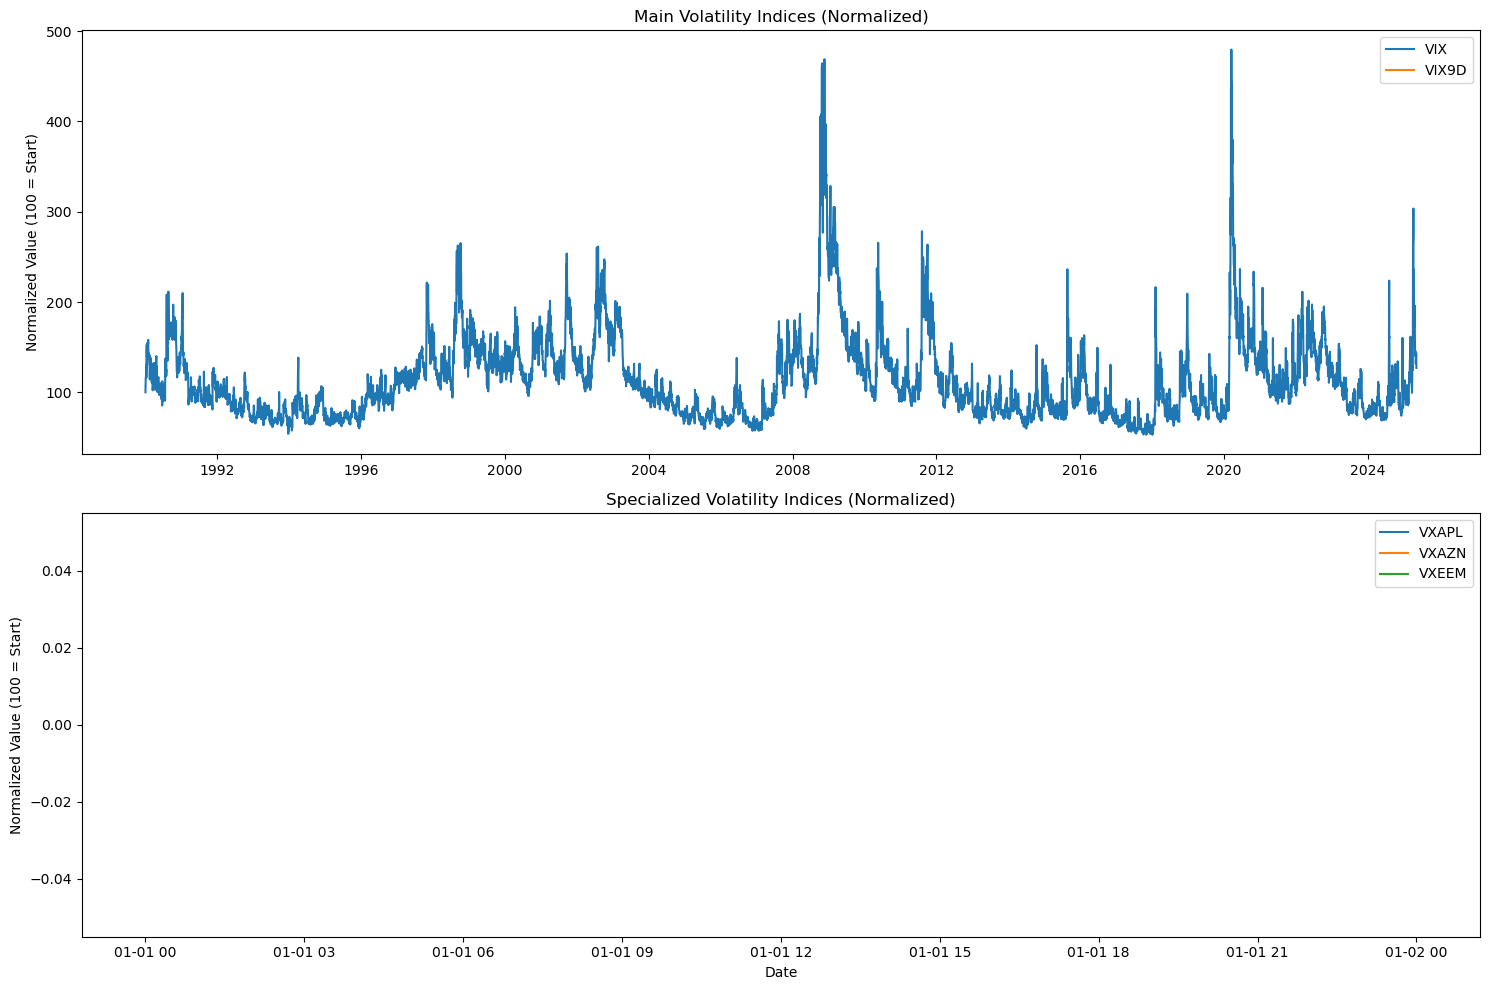

In [4]:
# New cell - Multi-volatility index analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

def load_volatility_indices(base_path="data/real/cboe_data/", indices=None):
    """
    Load multiple volatility indices and align them on dates
    
    Args:
        base_path: Path to data directory
        indices: List of index files to load (without .csv extension)
                 If None, loads all available *_History.csv files
    
    Returns:
        DataFrame with all indices aligned
    """
    if indices is None:
        # Find all volatility indices in the directory
        indices = []
        for file in os.listdir(base_path):
            if file.endswith("_History.csv"):
                indices.append(file.replace("_History.csv", ""))
    
    # Create a dictionary to store each index
    dfs = {}
    
    # Load each index
    for idx in indices:
        file_path = os.path.join(base_path, f"{idx}_History.csv")
        if os.path.exists(file_path):
            try:
                # Load the CSV
                df = pd.read_csv(file_path)
                
                # Standardize column names to lowercase
                df.columns = [col.lower() for col in df.columns]
                
                # Find the date column
                date_col = next((col for col in df.columns if 'date' in col.lower()), None)
                if date_col:
                    # Convert to datetime and set as index
                    df[date_col] = pd.to_datetime(df[date_col])
                    df.set_index(date_col, inplace=True)
                    
                    # Keep only the close price and rename it to the index
                    if 'close' in df.columns:
                        df = df[['close']].rename(columns={'close': idx})
                        dfs[idx] = df
                        print(f"Loaded {idx}: {len(df)} rows from {df.index.min()} to {df.index.max()}")
                    else:
                        print(f"Warning: 'close' column not found in {idx}")
                else:
                    print(f"Warning: No date column found in {idx}")
            except Exception as e:
                print(f"Error loading {idx}: {e}")
    
    # Merge all dataframes on index
    if dfs:
        merged_df = pd.concat(dfs.values(), axis=1)
        print(f"Merged dataset: {len(merged_df)} rows, {merged_df.shape[1]} columns")
        
        # Calculate basic completeness
        completeness = (merged_df.count() / len(merged_df)) * 100
        print("\nData completeness (%):")
        for col, pct in completeness.items():
            print(f"{col}: {pct:.1f}%")
        
        return merged_df
    else:
        print("No valid indices found")
        return None

# Load all volatility indices
vol_indices = load_volatility_indices()

# Visualize the indices
plt.figure(figsize=(15, 10))

# Plot each index, normalized to start at 100
normalized_indices = vol_indices.div(vol_indices.iloc[0]) * 100

# Create two subplots - one for main indices, one for specialized
plt.subplot(2, 1, 1)
for col in ['VIX', 'VVIX', 'VIX9D']:
    if col in normalized_indices.columns:
        plt.plot(normalized_indices.index, normalized_indices[col], label=col)
plt.title('Main Volatility Indices (Normalized)')
plt.ylabel('Normalized Value (100 = Start)')
plt.legend()

plt.subplot(2, 1, 2)
for col in ['OVX', 'GVZ', 'VXAPL', 'VXAZN', 'VXEEM']:
    if col in normalized_indices.columns:
        plt.plot(normalized_indices.index, normalized_indices[col], label=col)
plt.title('Specialized Volatility Indices (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Value (100 = Start)')
plt.legend()

plt.tight_layout()
plt.savefig('figures/meta_learning/vol_indices_comparison.png')
plt.show()

/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_30513/2748206565.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = indices_df.pct_change().dropna()


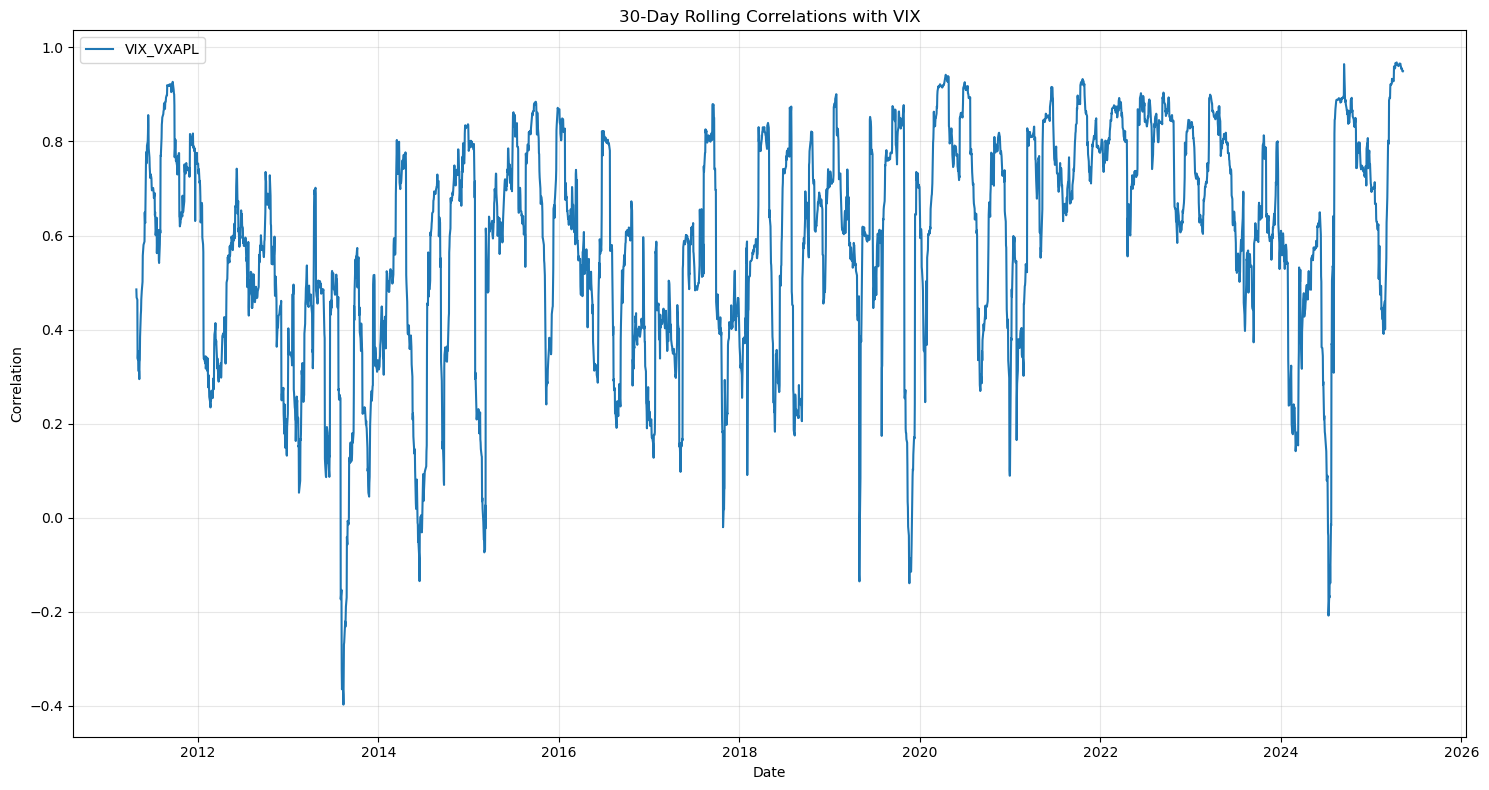

In [6]:
# New cell - Calculate volatility correlations
def calculate_rolling_correlations(indices_df, window=30):
    """
    Calculate rolling correlations between volatility indices
    
    Args:
        indices_df: DataFrame with volatility indices
        window: Rolling window size in days
        
    Returns:
        DataFrame with rolling correlations
    """
    # Calculate returns
    returns = indices_df.pct_change().dropna()
    
    # Create empty DataFrame to store correlations
    pairs = []
    for i, col1 in enumerate(returns.columns):
        for col2 in returns.columns[i+1:]:
            pairs.append(f"{col1}_{col2}")
    
    corr_df = pd.DataFrame(index=returns.index, columns=pairs)
    
    # Calculate rolling correlations
    for i, col1 in enumerate(returns.columns):
        for col2 in returns.columns[i+1:]:
            pair_name = f"{col1}_{col2}"
            corr_df[pair_name] = returns[col1].rolling(window).corr(returns[col2])
    
    return corr_df

# Calculate 30-day rolling correlations
rolling_corrs = calculate_rolling_correlations(vol_indices, window=30)

# Visualize key correlations
plt.figure(figsize=(15, 8))

# Plot VIX correlations with other indices
key_pairs = [col for col in rolling_corrs.columns if col.startswith('VIX_')]

for pair in key_pairs:
    plt.plot(rolling_corrs.index, rolling_corrs[pair], label=pair)

plt.title('30-Day Rolling Correlations with VIX')
plt.ylabel('Correlation')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/meta_learning/vix_correlations.png')
plt.show()

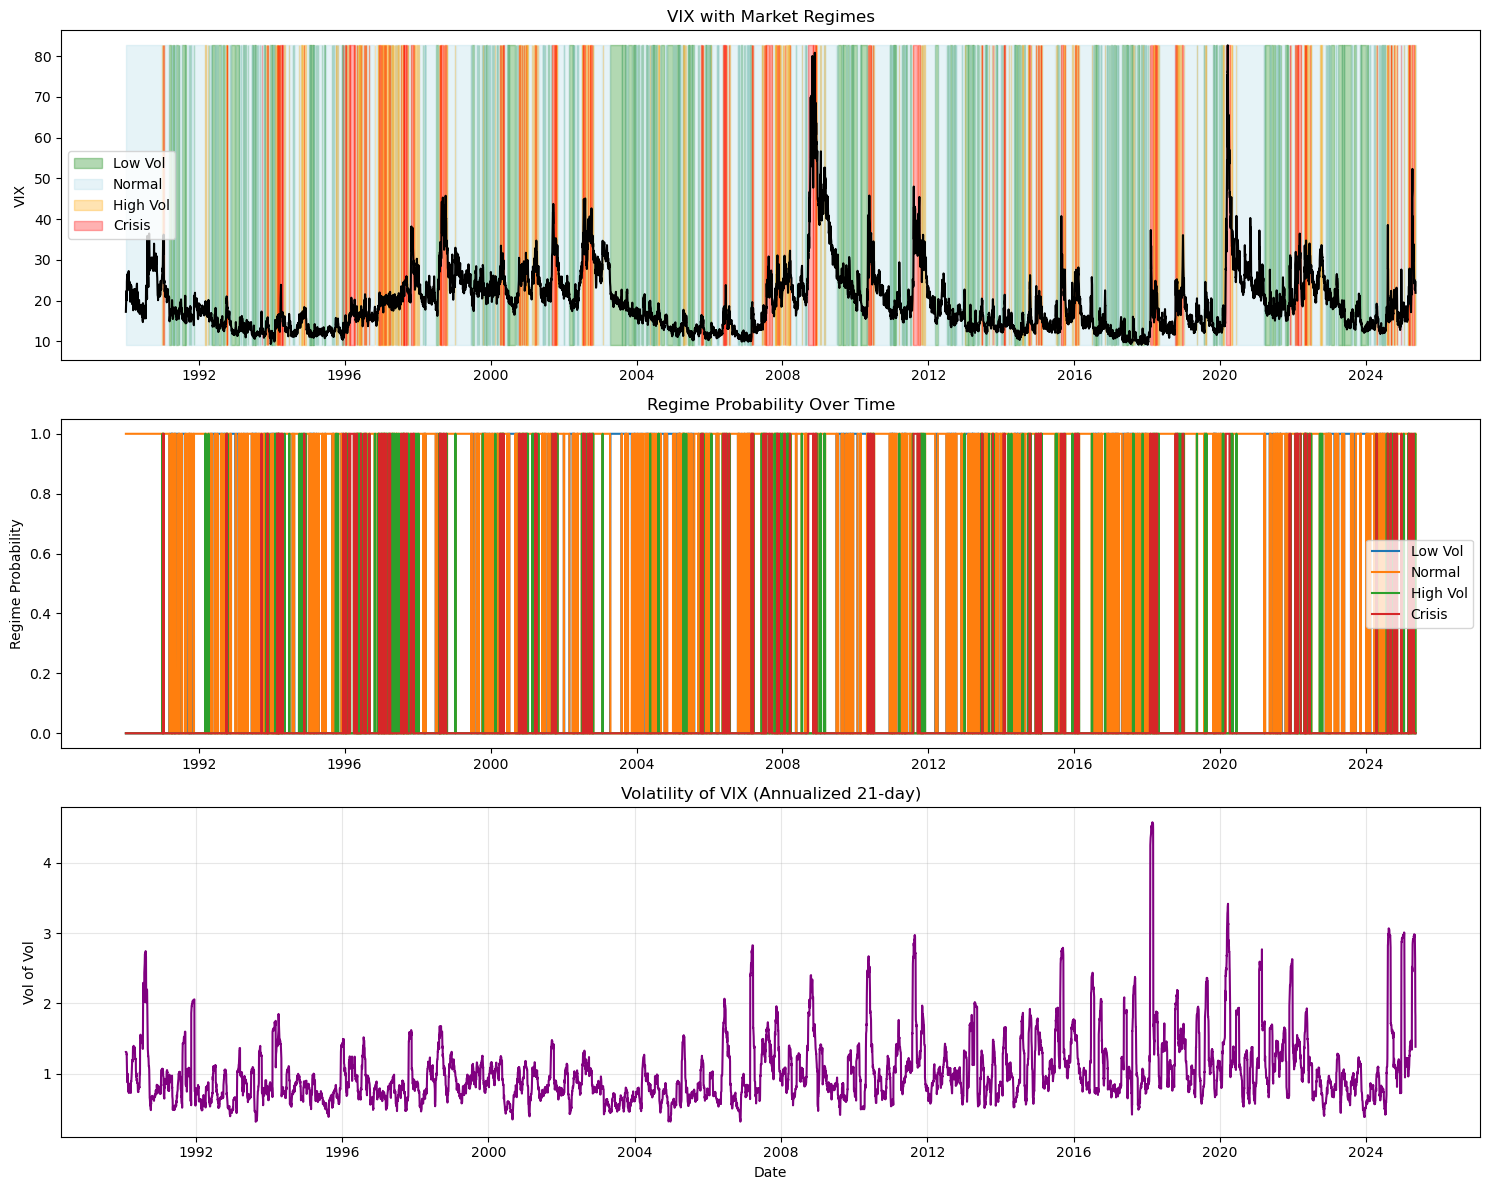

Saved regime classification to data/vix_regimes.csv

Regime Statistics:
          Count  Percentage
Low Vol    5470   61.295383
Normal     1911   21.414164
High Vol    940   10.533393
Crisis      603    6.757060


In [7]:
# New cell - Create regime classification
def identify_market_regimes(vix_data, lookback=252):
    """
    Classify market regimes based on VIX levels and trends
    
    Args:
        vix_data: DataFrame with VIX close prices
        lookback: Number of days to use for long-term statistics
        
    Returns:
        DataFrame with regime classifications
    """
    if 'VIX' not in vix_data.columns:
        vix_col = vix_data.columns[0]  # Use first column if VIX not found
    else:
        vix_col = 'VIX'
        
    df = vix_data.copy()
    
    # Calculate returns
    df['returns'] = df[vix_col].pct_change()
    
    # Calculate volatility of volatility (vol of VIX)
    df['vol_of_vol'] = df['returns'].rolling(21).std() * np.sqrt(252)
    
    # Calculate long-term statistics
    df['vix_mean'] = df[vix_col].rolling(lookback).mean()
    df['vix_std'] = df[vix_col].rolling(lookback).std()
    
    # Z-score of VIX relative to its history
    df['vix_zscore'] = (df[vix_col] - df['vix_mean']) / df['vix_std']
    
    # Regime classification
    # 0: Low volatility (VIX below -1 std dev)
    # 1: Normal volatility (VIX between -1 and +1 std dev)
    # 2: High volatility (VIX between +1 and +2 std dev)
    # 3: Crisis (VIX above +2 std dev)
    df['regime'] = 1  # Start with normal regime
    df.loc[df['vix_zscore'] < -1, 'regime'] = 0  # Low vol
    df.loc[df['vix_zscore'] > 1, 'regime'] = 2  # High vol
    df.loc[df['vix_zscore'] > 2, 'regime'] = 3  # Crisis
    
    # Additional classification based on VIX trend
    df['vix_trend'] = df[vix_col].pct_change(21)  # 21-day trend
    
    # Combine level and trend regimes
    df['regime_trend'] = df['regime'].astype(str)
    df.loc[df['vix_trend'] > 0.2, 'regime_trend'] += '_up'
    df.loc[df['vix_trend'] < -0.2, 'regime_trend'] += '_down'
    df.loc[(df['vix_trend'] >= -0.2) & (df['vix_trend'] <= 0.2), 'regime_trend'] += '_flat'
    
    # For meta-learning, create one-hot encoded regime indicators
    for r in range(4):  # 0, 1, 2, 3
        df[f'regime_{r}'] = (df['regime'] == r).astype(float)
        
    return df

# Apply regime classification to VIX data
if 'VIX' in vol_indices.columns:
    regime_df = identify_market_regimes(vol_indices[['VIX']])
else:
    # If VIX not present, use first column
    first_col = vol_indices.columns[0]
    regime_df = identify_market_regimes(vol_indices[[first_col]])

# Visualize regimes
plt.figure(figsize=(15, 12))

# Plot VIX with regime background
plt.subplot(3, 1, 1)
plt.plot(regime_df.index, regime_df['VIX'] if 'VIX' in regime_df.columns else regime_df.iloc[:, 0], 'k-')

# Color background by regime
colors = ['green', 'lightblue', 'orange', 'red']
regime_labels = ['Low Vol', 'Normal', 'High Vol', 'Crisis']

for i, (regime, color, label) in enumerate(zip(range(4), colors, regime_labels)):
    mask = regime_df['regime'] == regime
    if mask.any():
        plt.fill_between(regime_df.index, regime_df['VIX'].min() if 'VIX' in regime_df.columns else regime_df.iloc[:, 0].min(), 
                         regime_df['VIX'].max() if 'VIX' in regime_df.columns else regime_df.iloc[:, 0].max(), 
                         where=mask, color=color, alpha=0.3, label=label)

plt.title('VIX with Market Regimes')
plt.ylabel('VIX')
plt.legend()

# Plot regime distribution over time
plt.subplot(3, 1, 2)
for r in range(4):
    plt.plot(regime_df.index, regime_df[f'regime_{r}'], label=regime_labels[r])
plt.title('Regime Probability Over Time')
plt.ylabel('Regime Probability')
plt.legend()

# Plot volatility of volatility
plt.subplot(3, 1, 3)
plt.plot(regime_df.index, regime_df['vol_of_vol'], 'purple')
plt.title('Volatility of VIX (Annualized 21-day)')
plt.ylabel('Vol of Vol')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/vix_regimes.png')
plt.show()

# Save regime data for model training
regime_df.to_csv('data/vix_regimes.csv')
print(f"Saved regime classification to data/vix_regimes.csv")

# Summarize regime statistics
regime_stats = pd.DataFrame({
    'Count': regime_df['regime'].value_counts(),
    'Percentage': regime_df['regime'].value_counts(normalize=True) * 100
})
regime_stats.index = regime_labels
print("\nRegime Statistics:")
print(regime_stats)

In [8]:
# New cell - Prepare meta-learning task framework
def create_multi_index_dataset(vix_regimes_df, vol_indices_df, window_size=60, forecast_horizon=21, target_idx='VIX'):
    """
    Create a meta-learning dataset with multiple volatility indices as separate tasks
    
    Args:
        vix_regimes_df: DataFrame with VIX and regime classifications
        vol_indices_df: DataFrame with multiple volatility indices
        window_size: Input window size
        forecast_horizon: Forecast horizon
        target_idx: Default target index
        
    Returns:
        Dictionary with meta-learning dataset
    """
    # Get common dates
    common_dates = vix_regimes_df.index.intersection(vol_indices_df.index)
    indices = vol_indices_df.loc[common_dates].copy()
    regimes = vix_regimes_df.loc[common_dates].copy()
    
    # Initialize task ID mappings
    tasks = {}
    task_id = 0
    
    # Create datasets for each index
    datasets = {}
    task_map = {}
    
    # Process each volatility index
    for idx in indices.columns:
        # Skip indices with too many NaN values
        if indices[idx].isna().mean() > 0.2:  # Skip if more than 20% NaN
            print(f"Skipping {idx}: too many NaN values")
            continue
            
        # Create a dataset for this index
        idx_data = pd.DataFrame({
            'close': indices[idx],
            'vix': regimes['VIX'] if 'VIX' in regimes else regimes.iloc[:, 0],
            'regime': regimes['regime'],
            'vol_of_vol': regimes['vol_of_vol']
        })
        
        # Add regime indicators
        for r in range(4):
            if f'regime_{r}' in regimes:
                idx_data[f'regime_{r}'] = regimes[f'regime_{r}']
        
        # Fill any remaining NaN
        idx_data = idx_data.fillna(method='ffill').fillna(method='bfill')
        
        # Calculate returns and features
        idx_data['returns'] = idx_data['close'].pct_change()
        idx_data['vol_5d'] = idx_data['returns'].rolling(5).std() * np.sqrt(252)
        idx_data['vol_21d'] = idx_data['returns'].rolling(21).std() * np.sqrt(252)
        idx_data['mom_5d'] = idx_data['close'].pct_change(5)
        idx_data['mom_21d'] = idx_data['close'].pct_change(21)
        
        # Correlation with VIX
        if idx != 'VIX' and 'VIX' in indices:
            idx_data['corr_with_vix'] = idx_data['returns'].rolling(30).corr(indices['VIX'].pct_change())
        
        # Drop NaNs
        idx_data = idx_data.dropna()
        
        # Check if we have enough data
        if len(idx_data) < window_size + forecast_horizon:
            print(f"Skipping {idx}: not enough data after preprocessing")
            continue
            
        # Create X and y windows
        X_windows = []
        y_windows = []
        
        for i in range(len(idx_data) - window_size - forecast_horizon + 1):
            features = idx_data.iloc[i:i+window_size]
            target = idx_data['close'].iloc[i+window_size:i+window_size+forecast_horizon]
            
            # Convert to feature arrays
            feature_cols = [c for c in idx_data.columns if c != 'close']
            X = features[feature_cols].values
            y = target.values
            
            X_windows.append(X)
            y_windows.append(y)
        
        X_windows = np.array(X_windows)
        y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)
        
        # Assign task ID
        tasks[idx] = task_id
        task_ids = np.ones(len(X_windows), dtype=int) * task_id
        task_id += 1
        
        # Store the data
        datasets[idx] = {
            'X': X_windows,
            'y': y_windows,
            'task_ids': task_ids,
            'feature_cols': feature_cols
        }
        
        print(f"Created dataset for {idx}: {len(X_windows)} samples, {X_windows.shape[1]} timesteps, {X_windows.shape[2]} features")
    
    # Combine all tasks into one dataset
    if datasets:
        X_all = np.vstack([datasets[idx]['X'] for idx in datasets])
        y_all = np.vstack([datasets[idx]['y'] for idx in datasets])
        task_ids_all = np.concatenate([datasets[idx]['task_ids'] for idx in datasets])
        
        # Use same feature columns for all indices
        feature_cols = datasets[list(datasets.keys())[0]]['feature_cols']
        
        # Split into train/val/test
        n_samples = len(X_all)
        train_idx = int(n_samples * 0.7)
        val_idx = int(n_samples * 0.85)
        
        indices = np.random.permutation(n_samples)
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        test_indices = indices[val_idx:]
        
        meta_dataset = {
            'X_train': X_all[train_indices],
            'y_train': y_all[train_indices],
            'task_ids_train': task_ids_all[train_indices],
            
            'X_val': X_all[val_indices],
            'y_val': y_all[val_indices],
            'task_ids_val': task_ids_all[val_indices],
            
            'X_test': X_all[test_indices],
            'y_test': y_all[test_indices],
            'task_ids_test': task_ids_all[test_indices],
            
            'feature_cols': feature_cols,
            'task_map': {idx: task_id for idx, task_id in tasks.items()},
            'n_tasks': len(tasks)
        }
        
        print(f"\nCombined dataset:")
        print(f"  Training samples: {len(meta_dataset['X_train'])}")
        print(f"  Validation samples: {len(meta_dataset['X_val'])}")
        print(f"  Testing samples: {len(meta_dataset['X_test'])}")
        print(f"  Number of tasks: {meta_dataset['n_tasks']}")
        print(f"  Task mapping: {meta_dataset['task_map']}")
        
        return meta_dataset, datasets
    
    return None, None

# Create multi-index meta-learning dataset
meta_dataset, individual_datasets = create_multi_index_dataset(
    regime_df, vol_indices, window_size=60, forecast_horizon=21
)

# Save the multi-task dataset
if meta_dataset:
    torch.save(meta_dataset, 'data/meta_learning/multi_vol_meta_dataset.pt')
    print("Saved multi-task volatility dataset to data/meta_learning/multi_vol_meta_dataset.pt")

Skipping VXAZN: too many NaN values
Skipping VXEEM: too many NaN values
Skipping VIX9D: too many NaN values


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_30513/2480814136.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  idx_data = idx_data.fillna(method='ffill').fillna(method='bfill')


Created dataset for VIX: 8823 samples, 60 timesteps, 12 features
Skipping VXAPL: too many NaN values

Combined dataset:
  Training samples: 6176
  Validation samples: 1323
  Testing samples: 1324
  Number of tasks: 1
  Task mapping: {'VIX': 0}
Saved multi-task volatility dataset to data/meta_learning/multi_vol_meta_dataset.pt


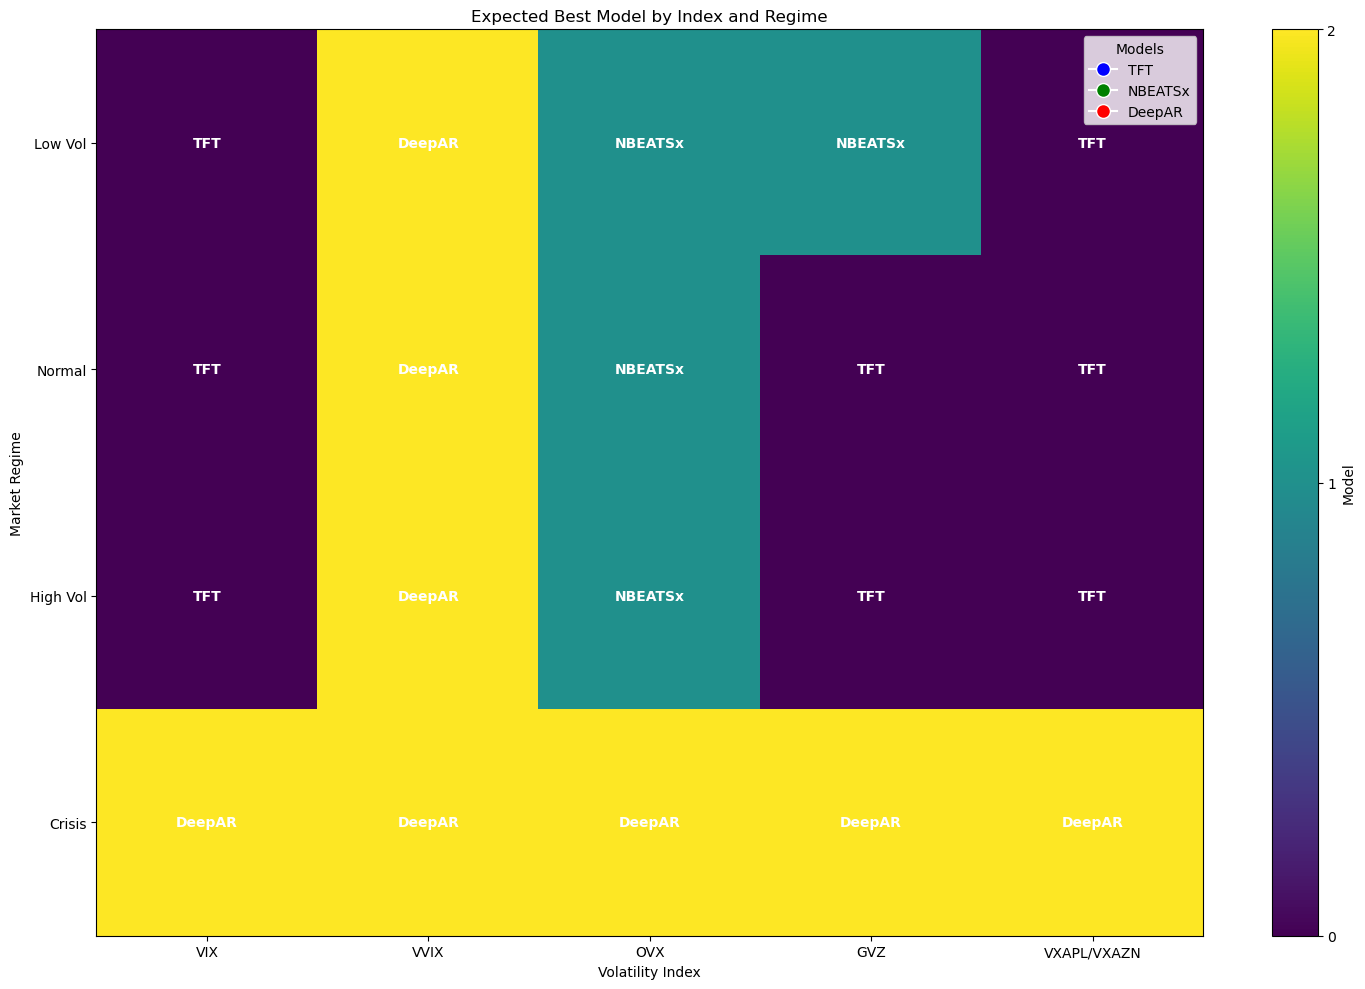

This analysis provides a theoretical prediction of which models might work best.
The meta-learning framework will learn the actual best models from data.


In [10]:
# New cell - Analyze which models work best for which volatility indices/regimes

def analyze_model_performance_by_regime():
    """
    Analyze which models work best for each market regime
    For visualization/planning - actual training will be done by the meta-learning framework
    """
    # Define model characteristics
    models = {
        'TFT': {
            'strengths': ['Handles mixed frequency data', 'Variable selection', 'Interpretable attention'],
            'best_for': ['Complex relationships', 'Multiple exogenous variables', 'Long-range dependencies'],
            'weaknesses': ['Requires more data', 'Slower training', 'More hyperparameters to tune']
        },
        'NBEATSx': {
            'strengths': ['Decomposition into trend/seasonality', 'Interpretable components', 'Handles exogenous variables'],
            'best_for': ['Clear trend or seasonality', 'Need for component analysis', 'Signal decomposition'],
            'weaknesses': ['Less effective for highly nonlinear relationships', 'Limited for multiple covariates']
        },
        'DeepAR': {
            'strengths': ['Probabilistic forecasts', 'Global model for multiple series', 'AutoRegressive structure'],
            'best_for': ['Stochastic processes', 'Multiple related time series', 'Uncertainty quantification'],
            'weaknesses': ['Less interpretable', 'Requires stationarity assumptions']
        }
    }
    
    # Regime characteristics
    regimes = {
        'Low Vol': {
            'characteristics': ['Stable trends', 'Lower uncertainty', 'Stronger autocorrelation'],
            'likely_best_model': 'NBEATSx',
            'reason': 'Clear trend patterns benefit from decomposition approach'
        },
        'Normal': {
            'characteristics': ['Mixed signals', 'Moderate predictability', 'Multiple factors at play'],
            'likely_best_model': 'TFT',
            'reason': 'Can handle complexity and variable importance changes'
        },
        'High Vol': {
            'characteristics': ['Increased uncertainty', 'Reduced autocorrelation', 'Bigger surprises'],
            'likely_best_model': 'DeepAR',
            'reason': 'Probabilistic approach handles increased uncertainty'
        },
        'Crisis': {
            'characteristics': ['Extreme events', 'Correlation breakdown', 'Nonlinear relationships'],
            'likely_best_model': 'DeepAR',
            'reason': 'Wide prediction intervals needed for extreme uncertainty'
        }
    }
    
    # Volatility index characteristics
    indices = {
        'VIX': {
            'characteristics': ['Equity volatility', 'Mean reverting', 'Regime switching'],
            'likely_best_model': 'TFT',
            'reason': 'Complex relationships with market factors'
        },
        'VVIX': {
            'characteristics': ['Volatility of volatility', 'Higher kurtosis', 'Fast changes'],
            'likely_best_model': 'DeepAR',
            'reason': 'Probabilistic approach for highly stochastic process'
        },
        'OVX': {
            'characteristics': ['Commodity volatility', 'Seasonal patterns', 'Supply/demand driven'],
            'likely_best_model': 'NBEATSx',
            'reason': 'Can capture seasonal patterns in commodities'
        },
        'GVZ': {
            'characteristics': ['Commodity volatility', 'Less cyclical than OVX', 'Safe haven effects'],
            'likely_best_model': 'TFT',
            'reason': 'Attention can capture safe haven relationships'
        },
        'VXAPL/VXAZN': {
            'characteristics': ['Single stock volatility', 'Company-specific events', 'Earnings driven'],
            'likely_best_model': 'TFT',
            'reason': 'Can attend to important events and variable selection'
        }
    }
    
    # Create a visualization of expected model performance
    plt.figure(figsize=(15, 10))
    
    # Create a matrix of regime vs. index with expected best model
    regime_names = list(regimes.keys())
    index_names = list(indices.keys())
    
    # Mapping of models to colors
    model_colors = {'TFT': 'blue', 'NBEATSx': 'green', 'DeepAR': 'red'}
    
    # Create matrix
    matrix = np.zeros((len(regime_names), len(index_names)))
    model_matrix = np.empty((len(regime_names), len(index_names)), dtype=object)
    
    # Fill with expected best model
    for i, regime in enumerate(regime_names):
        for j, idx in enumerate(index_names):
            # Simple logic to guess which model might work best
            # In a real scenario, this would be learned by the meta-learning framework
            regime_model = regimes[regime]['likely_best_model']
            index_model = indices[idx]['likely_best_model']
            
            # Choose model based on combination of factors
            if regime == 'Crisis':
                model_matrix[i, j] = 'DeepAR'  # In crisis, uncertainty is paramount
            elif regime == 'Low Vol' and (idx == 'OVX' or idx == 'GVZ'):
                model_matrix[i, j] = 'NBEATSx'  # For commodities in low vol, seasonality matters
            else:
                # Use the index-specific model 
                model_matrix[i, j] = index_model
                
            # Map to numeric
            matrix[i, j] = list(models.keys()).index(model_matrix[i, j])
    
    # Plot heatmap
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    
    # Add model names as text
    for i in range(len(regime_names)):
        for j in range(len(index_names)):
            plt.text(j, i, model_matrix[i, j], ha="center", va="center", 
                     color="white", fontweight="bold")
    
    plt.title('Expected Best Model by Index and Regime')
    plt.xlabel('Volatility Index')
    plt.ylabel('Market Regime')
    plt.xticks(range(len(index_names)), index_names)
    plt.yticks(range(len(regime_names)), regime_names)
    plt.colorbar(ticks=range(len(models)), label='Model')
    
    # Add a legend explaining the models
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=model_colors[model], markersize=10, label=model)
                      for model in models.keys()]
    plt.legend(handles=legend_elements, title="Models", loc='upper right')
    
    plt.tight_layout()
    plt.savefig('figures/meta_learning/expected_model_performance.png')
    plt.show()
    
    print("This analysis provides a theoretical prediction of which models might work best.")
    print("The meta-learning framework will learn the actual best models from data.")
    return models, regimes, indices

# Run the analysis
model_info, regime_info, index_info = analyze_model_performance_by_regime()

## After making some corrections for NaN values

In [11]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
# Cell 2: Define improved volatility indices loading function
def load_volatility_indices(base_path="data/real/cboe_data/", indices=None, min_overlap_pct=0.5):
    """
    Load multiple volatility indices with improved handling for unequal date ranges
    
    Args:
        base_path: Path to data directory
        indices: List of index files to load (without .csv extension)
        min_overlap_pct: Minimum percentage of dates that must overlap with primary index
    
    Returns:
        DataFrame with all indices aligned
    """
    if indices is None:
        # Find all volatility indices in the directory
        indices = []
        for file in os.listdir(base_path):
            if file.endswith("_History.csv"):
                indices.append(file.replace("_History.csv", ""))
    
    # Create a dictionary to store each index
    dfs = {}
    date_ranges = {}
    
    # Load each index
    for idx in indices:
        file_path = os.path.join(base_path, f"{idx}_History.csv")
        if os.path.exists(file_path):
            try:
                # Load the CSV
                df = pd.read_csv(file_path)
                
                # Standardize column names to lowercase
                df.columns = [col.lower() for col in df.columns]
                
                # Find the date column
                date_col = next((col for col in df.columns if 'date' in col.lower()), None)
                if date_col:
                    # Convert to datetime and set as index
                    df[date_col] = pd.to_datetime(df[date_col])
                    df.set_index(date_col, inplace=True)
                    
                    # Sort by date (some files might not be in chronological order)
                    df = df.sort_index()
                    
                    # Keep only the close price and rename it to the index
                    if 'close' in df.columns:
                        df = df[['close']].rename(columns={'close': idx})
                        dfs[idx] = df
                        date_ranges[idx] = (df.index.min(), df.index.max(), len(df))
                        print(f"Loaded {idx}: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")
                    else:
                        print(f"Warning: 'close' column not found in {idx}")
                else:
                    print(f"Warning: No date column found in {idx}")
            except Exception as e:
                print(f"Error loading {idx}: {e}")
    
    # Check if we have any valid data
    if not dfs:
        print("No valid indices found")
        return None
    
    # Determine the primary index with the most data points
    primary_idx = max(date_ranges.items(), key=lambda x: x[1][2])[0]
    primary_dates = dfs[primary_idx].index
    print(f"\nUsing {primary_idx} as primary index with {len(primary_dates)} data points")
    
    # Filter indices based on overlap with primary index
    valid_indices = []
    for idx, df in dfs.items():
        if idx == primary_idx:
            valid_indices.append(idx)
            continue
            
        # Calculate overlap percentage
        overlap_dates = df.index.intersection(primary_dates)
        overlap_pct = len(overlap_dates) / len(primary_dates)
        
        if overlap_pct >= min_overlap_pct:
            valid_indices.append(idx)
            print(f"{idx}: {overlap_pct:.2%} overlap with {primary_idx} ({len(overlap_dates)} dates)")
        else:
            print(f"Skipping {idx}: Insufficient overlap ({overlap_pct:.2%} < {min_overlap_pct:.2%})")
    
    # Merge valid indices
    if len(valid_indices) > 0:
        filtered_dfs = {idx: dfs[idx] for idx in valid_indices}
        merged_df = pd.concat(filtered_dfs.values(), axis=1)
        
        # Fill missing values using forward fill and then backward fill
        merged_df = merged_df.ffill().bfill()
        
        print(f"\nMerged dataset: {len(merged_df)} rows, {merged_df.shape[1]} columns")
        
        # Calculate basic completeness after filling
        completeness = (merged_df.count() / len(merged_df)) * 100
        print("\nData completeness (%):")
        for col, pct in completeness.items():
            print(f"{col}: {pct:.1f}%")
        
        # Visualize the indices
        plt.figure(figsize=(15, 10))
        
        # First, normalize to first valid value for each series
        normalized = pd.DataFrame()
        for col in merged_df.columns:
            normalized[col] = merged_df[col] / merged_df[col].iloc[0] * 100
        
        # Plot normalized values
        for col in normalized.columns:
            plt.plot(normalized.index, normalized[col], label=col)
            
        plt.title('Volatility Indices (Normalized to 100 at Start)')
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.savefig('results/volatility_indices.png')
        plt.show()
        
        return merged_df
    else:
        print("No valid indices found after filtering")
        return None

Loaded VXAZN: 3602 rows from 2011-01-07 to 2025-05-09
Loaded VXEEM: 3556 rows from 2011-03-16 to 2025-05-09
Loaded VIX9D: 3609 rows from 2011-01-04 to 2025-05-09
Loaded VIX: 8924 rows from 1990-01-02 to 2025-05-09
Loaded VXAPL: 3602 rows from 2011-01-07 to 2025-05-09

Using VIX as primary index with 8924 data points
VXAZN: 40.36% overlap with VIX (3602 dates)
Skipping VXEEM: Insufficient overlap (39.85% < 40.00%)
VIX9D: 40.44% overlap with VIX (3609 dates)
VXAPL: 40.36% overlap with VIX (3602 dates)

Merged dataset: 8924 rows, 4 columns

Data completeness (%):
VXAZN: 100.0%
VIX9D: 100.0%
VIX: 100.0%
VXAPL: 100.0%


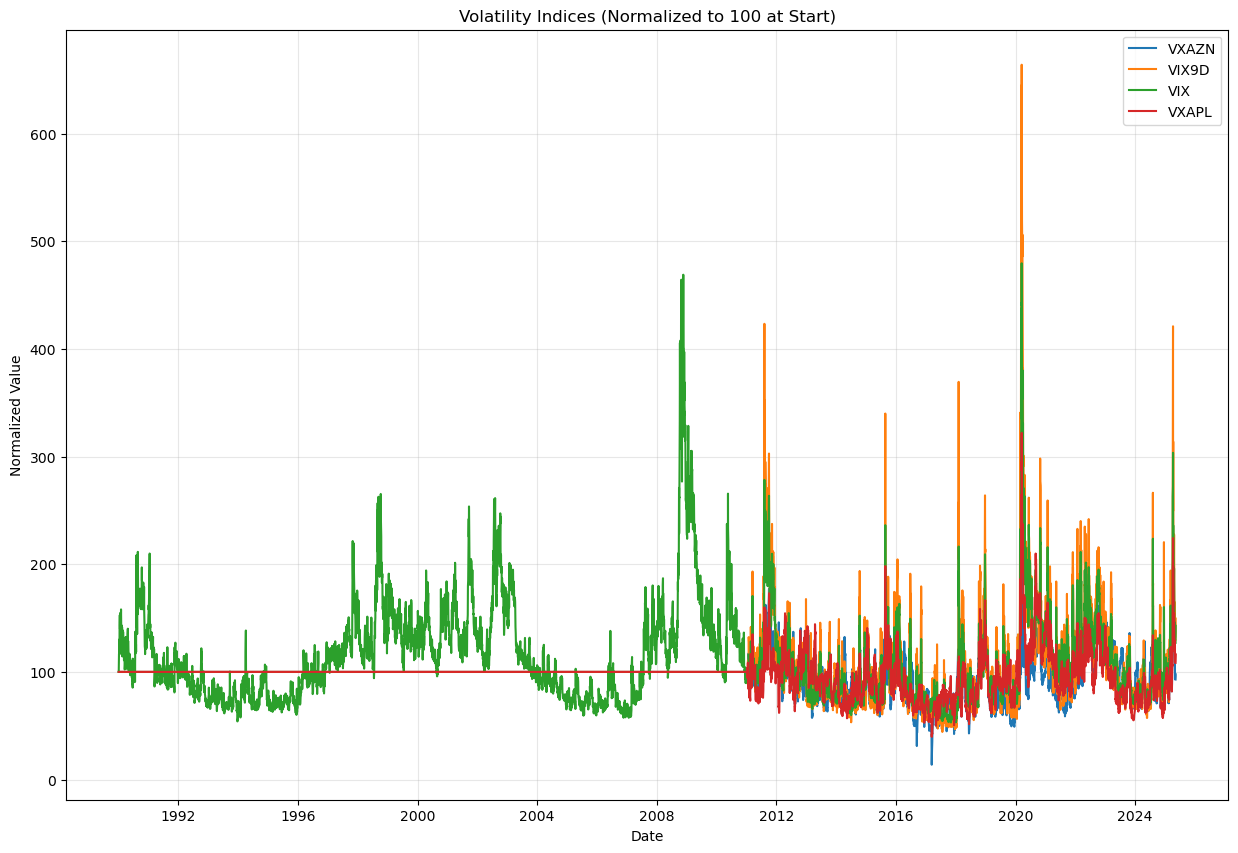

Saved merged volatility indices to data/meta_learning/merged_volatility_indices.csv


In [13]:
# Cell 3: Load and process volatility indices 
# Set minimum overlap percentage to 40% to include more indices
vol_indices = load_volatility_indices(min_overlap_pct=0.4)

# Save the merged indices for future use
if vol_indices is not None:
    vol_indices.to_csv('data/meta_learning/merged_volatility_indices.csv')
    print("Saved merged volatility indices to data/meta_learning/merged_volatility_indices.csv")

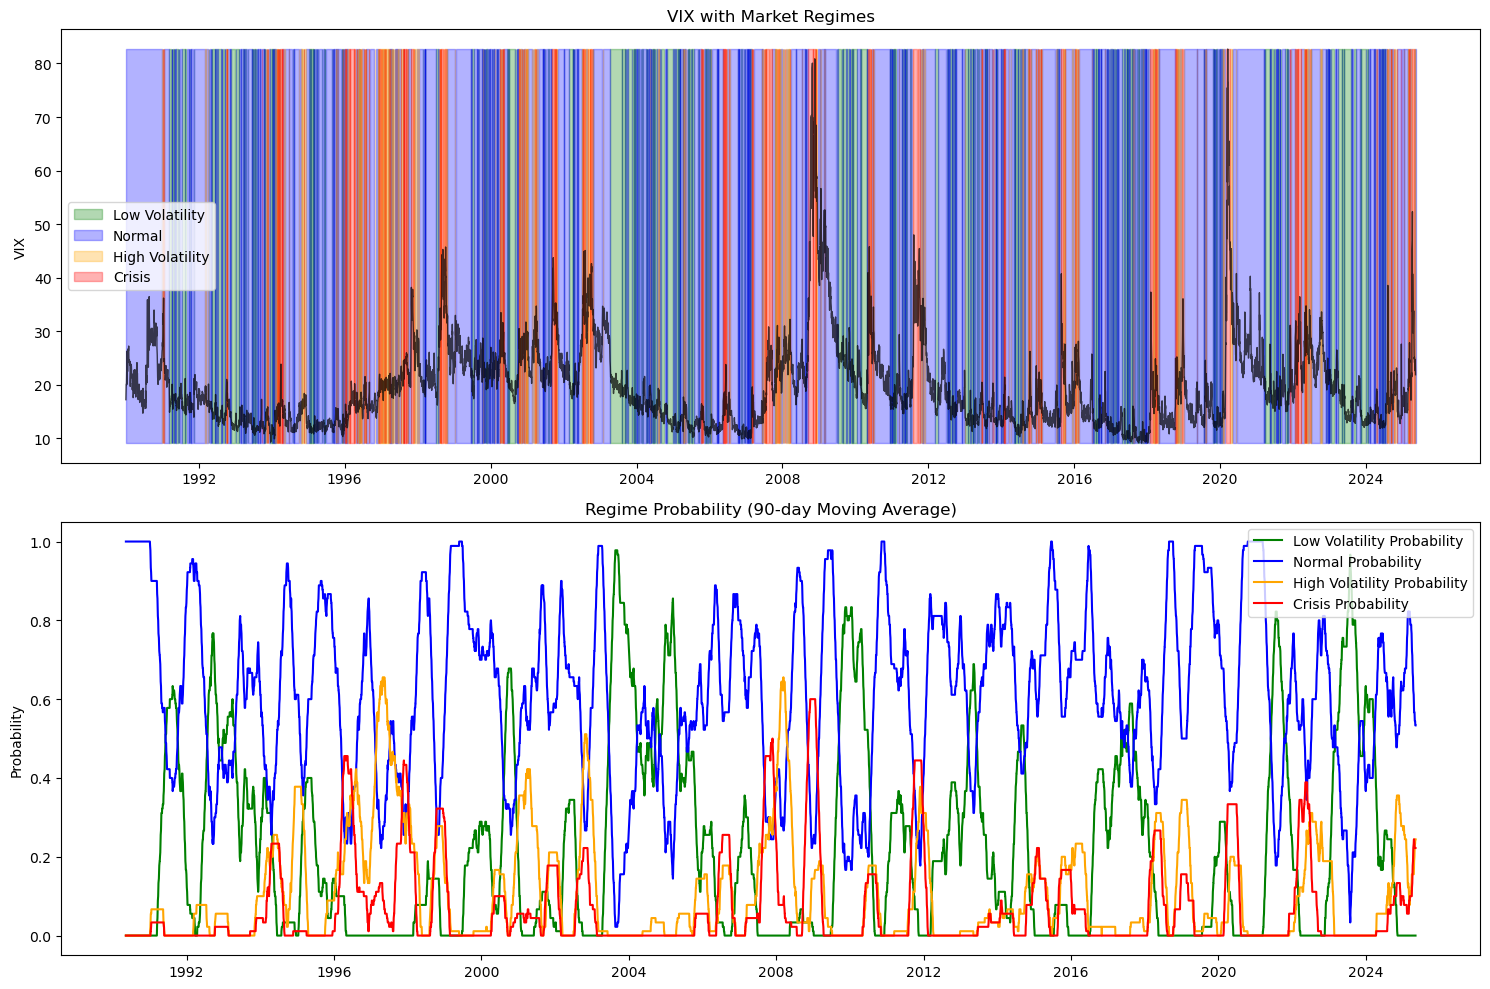

Regime Distribution:
Low Volatility: 1911 days (21.41%)
Normal: 5470 days (61.3%)
High Volatility: 940 days (10.53%)
Crisis: 603 days (6.76%)
Saved regime classification to data/meta_learning/volatility_regimes.csv


In [14]:
# Cell 4: Implement improved regime classification
def identify_market_regimes(vol_data, index_col='VIX', lookback=252):
    """
    Classify market regimes based on volatility index levels and trends
    
    Args:
        vol_data: DataFrame with volatility indices
        index_col: Column to use for regime classification
        lookback: Number of days for long-term statistics
        
    Returns:
        DataFrame with regime classifications
    """
    # Make a copy to avoid modifying the original
    df = vol_data.copy()
    
    # Ensure the index column exists
    if index_col not in df.columns and 'vix' in df.columns:
        index_col = 'vix'  # Fallback to lowercase
    
    if index_col not in df.columns:
        # Use the first column if specified column not found
        index_col = df.columns[0]
        print(f"Warning: Specified column not found. Using {index_col} instead.")
    
    # Calculate returns and volatility features
    df[f'{index_col}_returns'] = df[index_col].pct_change()
    
    # Calculate volatility of volatility (21-day rolling window)
    df[f'{index_col}_vol'] = df[f'{index_col}_returns'].rolling(21).std() * np.sqrt(252)
    
    # Calculate moving averages
    df[f'{index_col}_ma20'] = df[index_col].rolling(20).mean()
    df[f'{index_col}_ma50'] = df[index_col].rolling(50).mean()
    
    # Price to moving average ratios
    df[f'{index_col}_pct_ma20'] = df[index_col] / df[f'{index_col}_ma20']
    df[f'{index_col}_pct_ma50'] = df[index_col] / df[f'{index_col}_ma50']
    
    # Calculate z-score using long-term mean and std
    df[f'{index_col}_mean'] = df[index_col].rolling(lookback).mean()
    df[f'{index_col}_std'] = df[index_col].rolling(lookback).std()
    df[f'{index_col}_zscore'] = (df[index_col] - df[f'{index_col}_mean']) / df[f'{index_col}_std']
    
    # Calculate trend features
    df[f'{index_col}_trend_5d'] = df[index_col].pct_change(5)
    df[f'{index_col}_trend_21d'] = df[index_col].pct_change(21)
    
    # Initialize regime column (1: normal regime)
    df['regime'] = 1
    
    # Define regimes based on z-score
    # 0: Low volatility (below -1 std dev)
    # 1: Normal volatility (between -1 and +1 std dev)
    # 2: High volatility (between +1 and +2 std dev)
    # 3: Crisis (above +2 std dev)
    df.loc[df[f'{index_col}_zscore'] < -1, 'regime'] = 0  # Low vol
    df.loc[df[f'{index_col}_zscore'] > 1, 'regime'] = 2   # High vol
    df.loc[df[f'{index_col}_zscore'] > 2, 'regime'] = 3   # Crisis
    
    # Create regime indicators (one-hot encoding)
    for i in range(4):
        df[f'regime_{i}'] = (df['regime'] == i).astype(float)
    
    # Create a visualization of the regimes
    plt.figure(figsize=(15, 10))
    
    # Plot the index with color-coded regimes
    plt.subplot(211)
    colors = ['green', 'blue', 'orange', 'red']
    labels = ['Low Volatility', 'Normal', 'High Volatility', 'Crisis']
    
    # Plot the main line
    plt.plot(df.index, df[index_col], 'k-', linewidth=1, alpha=0.7)
    
    # Color the background based on regime
    min_val, max_val = df[index_col].min(), df[index_col].max()
    
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = df['regime'] == i
        if mask.any():
            plt.fill_between(df.index, min_val, max_val, 
                             where=mask, color=color, alpha=0.3, label=label)
    
    plt.title(f'{index_col} with Market Regimes')
    plt.ylabel(index_col)
    plt.legend()
    
    # Plot regime distribution over time
    plt.subplot(212)
    
    # Calculate 90-day moving average of regime probabilities
    smooth_window = 90
    for i, label in enumerate(labels):
        # Apply smoothing
        regime_smooth = df[f'regime_{i}'].rolling(smooth_window).mean()
        plt.plot(df.index, regime_smooth, color=colors[i], label=f'{label} Probability')
    
    plt.title('Regime Probability (90-day Moving Average)')
    plt.ylabel('Probability')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('results/market_regimes.png')
    plt.show()
    
    # Count regimes
    regime_counts = df['regime'].value_counts().sort_index()
    regime_pcts = (regime_counts / len(df) * 100).round(2)
    
    print("Regime Distribution:")
    for i, (count, pct) in enumerate(zip(regime_counts, regime_pcts)):
        print(f"{labels[i]}: {count} days ({pct}%)")
    
    return df

# Apply regime detection to the volatility indices
if vol_indices is not None:
    regime_df = identify_market_regimes(vol_indices)
    
    # Save the regime classifications
    regime_df.to_csv('data/meta_learning/volatility_regimes.csv')
    print("Saved regime classification to data/meta_learning/volatility_regimes.csv")

Creating multi-index forecasting dataset...
Task mapping: {'VXAZN': 0, 'VIX9D': 1, 'VIX': 2, 'VXAPL': 3}
Available columns in regime_df: ['VXAZN', 'VIX9D', 'VIX', 'VXAPL', 'VIX_returns', 'VIX_vol', 'VIX_ma20', 'VIX_ma50', 'VIX_pct_ma20', 'VIX_pct_ma50', 'VIX_mean', 'VIX_std', 'VIX_zscore', 'VIX_trend_5d', 'VIX_trend_21d', 'regime', 'regime_0', 'regime_1', 'regime_2', 'regime_3']
Using 12 feature columns and 4 regime columns
Processing VXAZN...
  Processed data shape: (8924, 12), columns: ['close', 'VXAZN', 'regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime', 'returns', 'vol_5d', 'vol_21d', 'mom_5d', 'mom_21d']
Processing VIX9D...
  Processed data shape: (8924, 13), columns: ['close', 'VXAZN', 'regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime', 'returns', 'vol_5d', 'vol_21d', 'mom_5d', 'mom_21d', 'corr_with_VXAZN']
Processing VIX...
  Processed data shape: (8924, 24), columns: ['close', 'VXAZN', 'regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime', 'VIX_returns', 'VIX_vol

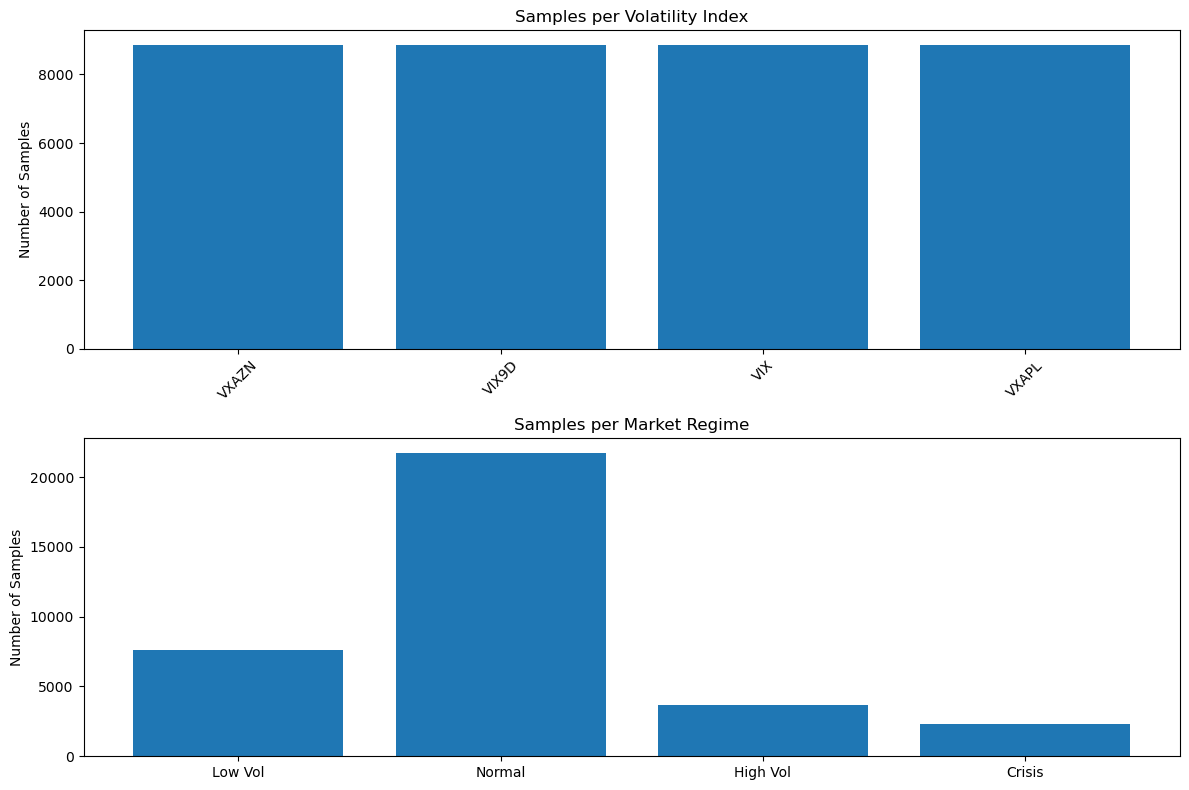


Saved datasets to:
  - data/meta_learning/meta_learning_dataset.pt
  - data/meta_learning/individual_datasets.pt

Saving datasets as CSV files for inspection...
Saved feature information to 'data/meta_learning/csv/meta_features.csv'
Saved task mapping to 'data/meta_learning/csv/task_mapping.csv'
Saved 10 sample input/target pairs to 'data/meta_learning/csv/' folder
Saved summary and sample data for 4 individual datasets
CSV files saved successfully. You can now examine the data structure in any spreadsheet program.


In [17]:
# Cell 5 (fixed dimension issue): Define enhanced meta-feature extraction and prepare multi-task data
def create_multi_index_dataset(regime_df, vol_indices_df, window_size=60, forecast_horizon=21):
    """
    Create a meta-learning dataset with improved robustness for multiple volatility indices
    
    Args:
        regime_df: DataFrame with regime classifications
        vol_indices_df: DataFrame with multiple volatility indices
        window_size: Input window size
        forecast_horizon: Forecast horizon
        
    Returns:
        Dictionary with meta-learning dataset and individual datasets by index
    """
    print("Creating multi-index forecasting dataset...")
    
    # Get indices with enough data
    indices = vol_indices_df.columns.tolist()
    primary_index = indices[0]  # Use first column as primary index
    
    # Initialize task IDs
    task_map = {idx: i for i, idx in enumerate(indices)}
    print(f"Task mapping: {task_map}")
    
    # Create datasets for each index
    datasets = {}
    
    # Print column information for debugging
    print(f"Available columns in regime_df: {regime_df.columns.tolist()}")
    
    # Get common columns from regime_df for features
    # Ensure we only use columns that actually exist
    all_cols = regime_df.columns.tolist()
    feature_cols = [col for col in all_cols if col not in indices and not col.startswith('regime_')]
    regime_cols = [col for col in all_cols if col.startswith('regime_')]
    
    print(f"Using {len(feature_cols)} feature columns and {len(regime_cols)} regime columns")
    
    # Process each volatility index
    all_feature_sets = []  # Track all feature sets to standardize later
    
    for idx in indices:
        # Create features for this index
        print(f"Processing {idx}...")
        
        # First, extract main time series
        if idx in regime_df.columns:
            # The index is already in the regime dataframe
            idx_series = regime_df[idx]
        else:
            # The index needs to be merged
            idx_series = vol_indices_df[idx]
        
        # Create a DataFrame for this index
        idx_data = pd.DataFrame({
            'close': idx_series,
        })
        
        # Add primary index for reference (using the correct column name)
        if primary_index in regime_df.columns:
            idx_data[primary_index] = regime_df[primary_index]
        
        # Add regime columns
        for col in regime_cols:
            idx_data[col] = regime_df[col]
        
        # Add regime column
        if 'regime' in regime_df.columns:
            idx_data['regime'] = regime_df['regime']
        
        # Add other features from regime_df if they exist and don't include other indices
        for col in feature_cols:
            try:
                # Only include features relevant to this index or general features
                if idx.lower() in col.lower() or not any(other_idx.lower() in col.lower() for other_idx in indices):
                    idx_data[col] = regime_df[col]
            except KeyError:
                # Skip columns that don't exist
                print(f"  Skipping column {col} (not found in data)")
                continue
        
        # Calculate returns if not already present
        if 'returns' not in idx_data.columns:
            idx_data['returns'] = idx_data['close'].pct_change()
        
        # Calculate volatility features if not already present
        if 'vol_5d' not in idx_data.columns:
            idx_data['vol_5d'] = idx_data['returns'].rolling(5).std() * np.sqrt(252)
        if 'vol_21d' not in idx_data.columns:
            idx_data['vol_21d'] = idx_data['returns'].rolling(21).std() * np.sqrt(252)
        
        # Calculate momentum features if not already present
        if 'mom_5d' not in idx_data.columns:
            idx_data['mom_5d'] = idx_data['close'].pct_change(5)
        if 'mom_21d' not in idx_data.columns:
            idx_data['mom_21d'] = idx_data['close'].pct_change(21)
        
        # Correlation with primary index (if different)
        if idx != primary_index:
            corr_col = f'corr_with_{primary_index}'
            idx_data[corr_col] = idx_data['returns'].rolling(30).corr(
                regime_df[primary_index].pct_change() if primary_index in regime_df.columns else vol_indices_df[primary_index].pct_change()
            )
        
        # Fill NaN values
        idx_data = idx_data.ffill().bfill()
        
        # Drop any remaining NaNs
        idx_data = idx_data.dropna()
        
        # Get feature columns (exclude 'close' which is the target)
        index_feature_cols = [col for col in idx_data.columns if col != 'close']
        all_feature_sets.append(index_feature_cols)
        
        # Print column stats
        print(f"  Processed data shape: {idx_data.shape}, columns: {idx_data.columns.tolist()}")
        
        # Store for later
        datasets[idx] = {
            'data': idx_data,
            'feature_cols': index_feature_cols
        }
    
    # Find common features across all datasets to ensure consistent dimensions
    # Create a union of all feature sets
    all_features = set()
    for feature_set in all_feature_sets:
        all_features.update(feature_set)
    all_features = sorted(list(all_features))
    
    print(f"Standardizing to {len(all_features)} features across all indices: {all_features}")
    
    # Create windows with standardized features
    for idx, dataset_info in datasets.items():
        print(f"Creating standardized windows for {idx}...")
        idx_data = dataset_info['data']
        
        # Ensure all features exist
        for col in all_features:
            if col not in idx_data.columns:
                # Add missing feature as zeros
                idx_data[col] = 0
        
        # Create X and y windows
        X_windows = []
        y_windows = []
        window_dates = []
        
        # Verify we have enough data
        if len(idx_data) < window_size + forecast_horizon:
            print(f"  Warning: {idx} has insufficient data after preprocessing")
            continue
            
        for i in range(len(idx_data) - window_size - forecast_horizon + 1):
            # Extract windows
            feature_window = idx_data.iloc[i:i+window_size]
            target_window = idx_data['close'].iloc[i+window_size:i+window_size+forecast_horizon]
            
            # Store window dates
            window_dates.append((
                feature_window.index[0],  # Start date
                feature_window.index[-1],  # End date
                target_window.index[-1]   # Forecast end date
            ))
            
            # Convert to feature arrays - use standardized feature list
            X = feature_window[all_features].values
            y = target_window.values
            
            X_windows.append(X)
            y_windows.append(y)
        
        # Convert to numpy arrays
        X_windows = np.array(X_windows)
        y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)
        
        # Convert window dates to DataFrame
        date_df = pd.DataFrame(window_dates, columns=['start_date', 'end_date', 'forecast_end_date'])
        
        # Create task IDs array
        task_ids = np.ones(len(X_windows), dtype=int) * task_map[idx]
        
        # Store dataset with standardized features
        datasets[idx] = {
            'X': X_windows,
            'y': y_windows,
            'task_ids': task_ids,
            'feature_cols': all_features,
            'dates': date_df
        }
        
        print(f"  Created dataset for {idx}: {len(X_windows)} samples, {X_windows.shape[1]} timesteps, {X_windows.shape[2]} features")
    
    # Combine all tasks for meta-learning
    combined_X = []
    combined_y = []
    combined_task_ids = []
    combined_dates = []
    
    for idx, dataset in datasets.items():
        if 'X' in dataset:  # Only include datasets that were successfully processed
            combined_X.append(dataset['X'])
            combined_y.append(dataset['y'])
            combined_task_ids.append(dataset['task_ids'])
            
            # Add index name to dates DataFrame
            dates_copy = dataset['dates'].copy()
            dates_copy['index'] = idx
            combined_dates.append(dates_copy)
    
    # Concatenate everything
    if combined_X:
        all_X = np.vstack(combined_X)
        all_y = np.vstack(combined_y)
        all_task_ids = np.concatenate(combined_task_ids)
        all_dates = pd.concat(combined_dates, ignore_index=True)
        
        # Get feature columns from the first dataset (assuming all have the same structure)
        first_idx = list(datasets.keys())[0]
        all_feature_cols = datasets[first_idx]['feature_cols']
        
        # Split into train/val/test (70/15/15 split)
        n_samples = len(all_X)
        indices = np.random.permutation(n_samples)
        
        train_end = int(n_samples * 0.7)
        val_end = int(n_samples * 0.85)
        
        train_indices = indices[:train_end]
        val_indices = indices[train_end:val_end]
        test_indices = indices[val_end:]
        
        # Create the meta-dataset
        meta_dataset = {
            'X_train': all_X[train_indices],
            'y_train': all_y[train_indices],
            'task_ids_train': all_task_ids[train_indices],
            'dates_train': all_dates.iloc[train_indices].reset_index(drop=True),
            
            'X_val': all_X[val_indices],
            'y_val': all_y[val_indices],
            'task_ids_val': all_task_ids[val_indices],
            'dates_val': all_dates.iloc[val_indices].reset_index(drop=True),
            
            'X_test': all_X[test_indices],
            'y_test': all_y[test_indices],
            'task_ids_test': all_task_ids[test_indices],
            'dates_test': all_dates.iloc[test_indices].reset_index(drop=True),
            
            'feature_cols': all_feature_cols,
            'task_map': task_map,
            'n_tasks': len(task_map)
        }
        
        print("\nCreated combined meta-learning dataset:")
        print(f"  Training samples: {len(meta_dataset['X_train'])}")
        print(f"  Validation samples: {len(meta_dataset['X_val'])}")
        print(f"  Testing samples: {len(meta_dataset['X_test'])}")
        print(f"  Number of indices/tasks: {meta_dataset['n_tasks']}")
        
        # Create visualization of data distribution
        plt.figure(figsize=(12, 8))
        plt.subplot(211)
        
        task_dist = {}
        for idx, task_id in task_map.items():
            task_dist[idx] = np.sum(all_task_ids == task_id)
        
        plt.bar(task_dist.keys(), task_dist.values())
        plt.title('Samples per Volatility Index')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)
        
        plt.subplot(212)
        regime_dist = {}
        for i in range(4):
            regime_key = f'regime_{i}'
            if regime_key in all_feature_cols:
                # Get the column index
                col_idx = all_feature_cols.index(regime_key)
                # Count samples where regime indicator is 1
                regime_dist[i] = np.sum(all_X[:, 0, col_idx] > 0.5)  # First timestep, regime column
        
        # Define regime labels
        regime_labels = ['Low Vol', 'Normal', 'High Vol', 'Crisis']
        plt.bar([regime_labels[i] for i in regime_dist.keys()], regime_dist.values())
        plt.title('Samples per Market Regime')
        plt.ylabel('Number of Samples')
        
        plt.tight_layout()
        plt.savefig('results/dataset_distribution.png')
        plt.show()
        
        return meta_dataset, datasets
    else:
        print("No valid datasets created")
        return None, None

# Create the meta-learning dataset
if 'regime_df' in locals() and vol_indices is not None:
    meta_dataset, individual_datasets = create_multi_index_dataset(
        regime_df, vol_indices, window_size=60, forecast_horizon=21
    )


    
    # Save the datasets
    if meta_dataset is not None:
        torch.save(meta_dataset, 'data/meta_learning/meta_learning_dataset.pt')
        torch.save(individual_datasets, 'data/meta_learning/individual_datasets.pt')
        print("\nSaved datasets to:")
        print("  - data/meta_learning/meta_learning_dataset.pt")
        print("  - data/meta_learning/individual_datasets.pt")

    # Add to the end of Cell 5: Save datasets as CSV files
def save_datasets_as_csv(meta_dataset, individual_datasets):
    """
    Save meta-learning dataset and individual datasets as CSV files for inspection
    
    Args:
        meta_dataset: Meta-learning dataset dictionary
        individual_datasets: Dictionary of individual datasets
    """
    print("\nSaving datasets as CSV files for inspection...")
    
    # Create folder for CSV files
    os.makedirs('data/meta_learning/csv', exist_ok=True)
    
    # 1. Save meta-dataset information
    if meta_dataset is not None:
        # Save feature information
        feature_info = pd.DataFrame({
            'feature_name': meta_dataset['feature_cols']
        })
        feature_info.to_csv('data/meta_learning/csv/meta_features.csv', index=False)
        print("Saved feature information to 'data/meta_learning/csv/meta_features.csv'")
        
        # Save task mapping
        task_map = pd.DataFrame([
            {'task_id': task_id, 'index_name': idx_name}
            for idx_name, task_id in meta_dataset['task_map'].items()
        ])
        task_map.to_csv('data/meta_learning/csv/task_mapping.csv', index=False)
        print("Saved task mapping to 'data/meta_learning/csv/task_mapping.csv'")
        
        # Save sample of the training data (first 1000 rows)
        # X_train
        sample_size = min(1000, len(meta_dataset['X_train']))
        for i in range(sample_size):
            # Save one sample per file (to keep files manageable)
            sample_df = pd.DataFrame(
                meta_dataset['X_train'][i], 
                columns=meta_dataset['feature_cols']
            )
            sample_df['timestep'] = range(len(sample_df))
            
            # Add target data
            target_df = pd.DataFrame({
                'target': meta_dataset['y_train'][i, :, 0],
                'timestep': range(len(meta_dataset['X_train'][i]), 
                                 len(meta_dataset['X_train'][i]) + len(meta_dataset['y_train'][i]))
            })
            
            # Add task information
            task_id = meta_dataset['task_ids_train'][i]
            task_name = next(k for k, v in meta_dataset['task_map'].items() if v == task_id)
            
            # Save to CSV (only save a few samples to avoid too many files)
            if i < 10:
                sample_df.to_csv(f'data/meta_learning/csv/sample_{i}_input_{task_name}.csv', index=False)
                target_df.to_csv(f'data/meta_learning/csv/sample_{i}_target_{task_name}.csv', index=False)
                
        print(f"Saved {min(10, sample_size)} sample input/target pairs to 'data/meta_learning/csv/' folder")
    
    # 2. Save samples from individual datasets
    if individual_datasets is not None:
        for idx, dataset in individual_datasets.items():
            if 'X' not in dataset:
                continue
                
            # Save summary information
            summary = {
                'index_name': idx,
                'num_samples': len(dataset['X']),
                'input_timesteps': dataset['X'].shape[1],
                'num_features': dataset['X'].shape[2],
                'forecast_horizon': dataset['y'].shape[1]
            }
            
            summary_df = pd.DataFrame([summary])
            summary_df.to_csv(f'data/meta_learning/csv/{idx}_summary.csv', index=False)
            
            # Save first sample
            if len(dataset['X']) > 0:
                sample_df = pd.DataFrame(
                    dataset['X'][0], 
                    columns=dataset['feature_cols']
                )
                sample_df['timestep'] = range(len(sample_df))
                sample_df.to_csv(f'data/meta_learning/csv/{idx}_sample_input.csv', index=False)
                
                target_df = pd.DataFrame({
                    'target': dataset['y'][0, :, 0],
                    'timestep': range(len(dataset['X'][0]), 
                                     len(dataset['X'][0]) + len(dataset['y'][0]))
                })
                target_df.to_csv(f'data/meta_learning/csv/{idx}_sample_target.csv', index=False)
        
        print(f"Saved summary and sample data for {len(individual_datasets)} individual datasets")
    
    print("CSV files saved successfully. You can now examine the data structure in any spreadsheet program.")

# Call the function to save CSV files if meta-dataset exists
if meta_dataset is not None and individual_datasets is not None:
    save_datasets_as_csv(meta_dataset, individual_datasets)


In [ ]:
# Add to the end of Cell 5: Save datasets as CSV files
def save_datasets_as_csv(meta_dataset, individual_datasets):
    """
    Save meta-learning dataset and individual datasets as CSV files for inspection
    
    Args:
        meta_dataset: Meta-learning dataset dictionary
        individual_datasets: Dictionary of individual datasets
    """
    print("\nSaving datasets as CSV files for inspection...")
    
    # Create folder for CSV files
    os.makedirs('data/meta_learning/csv', exist_ok=True)
    
    # 1. Save meta-dataset information
    if meta_dataset is not None:
        # Save feature information
        feature_info = pd.DataFrame({
            'feature_name': meta_dataset['feature_cols']
        })
        feature_info.to_csv('data/meta_learning/csv/meta_features.csv', index=False)
        print("Saved feature information to 'data/meta_learning/csv/meta_features.csv'")
        
        # Save task mapping
        task_map = pd.DataFrame([
            {'task_id': task_id, 'index_name': idx_name}
            for idx_name, task_id in meta_dataset['task_map'].items()
        ])
        task_map.to_csv('data/csv/task_mapping.csv', index=False)
        print("Saved task mapping to 'data/meta_learning/csv/task_mapping.csv'")
        
        # Save sample of the training data (first 1000 rows)
        # X_train
        sample_size = min(1000, len(meta_dataset['X_train']))
        for i in range(sample_size):
            # Save one sample per file (to keep files manageable)
            sample_df = pd.DataFrame(
                meta_dataset['X_train'][i], 
                columns=meta_dataset['feature_cols']
            )
            sample_df['timestep'] = range(len(sample_df))
            
            # Add target data
            target_df = pd.DataFrame({
                'target': meta_dataset['y_train'][i, :, 0],
                'timestep': range(len(meta_dataset['X_train'][i]), 
                                 len(meta_dataset['X_train'][i]) + len(meta_dataset['y_train'][i]))
            })
            
            # Add task information
            task_id = meta_dataset['task_ids_train'][i]
            task_name = next(k for k, v in meta_dataset['task_map'].items() if v == task_id)
            
            # Save to CSV (only save a few samples to avoid too many files)
            if i < 10:
                sample_df.to_csv(f'data/meta_learning/csv/sample_{i}_input_{task_name}.csv', index=False)
                target_df.to_csv(f'data/meta_learning/csv/sample_{i}_target_{task_name}.csv', index=False)
                
        print(f"Saved {min(10, sample_size)} sample input/target pairs to 'data/meta_learning/csv/' folder")
    
    # 2. Save samples from individual datasets
    if individual_datasets is not None:
        for idx, dataset in individual_datasets.items():
            if 'X' not in dataset:
                continue
                
            # Save summary information
            summary = {
                'index_name': idx,
                'num_samples': len(dataset['X']),
                'input_timesteps': dataset['X'].shape[1],
                'num_features': dataset['X'].shape[2],
                'forecast_horizon': dataset['y'].shape[1]
            }
            
            summary_df = pd.DataFrame([summary])
            summary_df.to_csv(f'data/meta_learning/csv/{idx}_summary.csv', index=False)
            
            # Save first sample
            if len(dataset['X']) > 0:
                sample_df = pd.DataFrame(
                    dataset['X'][0], 
                    columns=dataset['feature_cols']
                )
                sample_df['timestep'] = range(len(sample_df))
                sample_df.to_csv(f'data/meta_learning/csv/{idx}_sample_input.csv', index=False)
                
                target_df = pd.DataFrame({
                    'target': dataset['y'][0, :, 0],
                    'timestep': range(len(dataset['X'][0]), 
                                     len(dataset['X'][0]) + len(dataset['y'][0]))
                })
                target_df.to_csv(f'data/meta_learning/csv/{idx}_sample_target.csv', index=False)
        
        print(f"Saved summary and sample data for {len(individual_datasets)} individual datasets")
    
    print("CSV files saved successfully. You can now examine the data structure in any spreadsheet program.")

# Call the function to save CSV files if meta-dataset exists
if meta_dataset is not None and individual_datasets is not None:
    save_datasets_as_csv(meta_dataset, individual_datasets)

NameError: name 'meta_dataset' is not defined